<a href="https://colab.research.google.com/github/AndresMontesDeOca/Laboratorio3/blob/main/Experimento.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pendientes y To-Do


**Log:**
- Pruebas iniciales, Mean 12 meses y Igual a Dec 2019.
- Se observa la tendencia negatvia
- Tambien se observa la bajada de ventas en Aug 2018. Probamos mean, jul*1.1, del aug
- Los 74 productos mas importantes de los 780, representan un 66% de las toneladas totales vendidas
- Verificamos que productos se vendieron los 36 meses, y cuales son productos nuevos
- Modelo Loco: Analisis de ventas en los Febrero en relacion al promedio del ano anterior. Los productos con ratio similar en 2017 y 2018, se predijeron de la misma manera para 2019
- Parametros Fijos: Horizon de 2 (mes +2) | Batcn Size de 32 | Loss "MSE" | Optimzer "Adam" | Epochs 500 | EarlyStop 20
- Armamos una red neuronal BASELINE por 1x Capa Conv + MaxPool, 3x Capa LSTM BiDireccional, 1x Capa Dropuput (%30)
- Probamos con varias distintas configuraciones de modelos con distintas capas y neuronas
- Tambien probamos distintos tamanos de Window (3, 6 y 12), y por ahora nos quedamos con 3
- Mucha varianza en los modelos. Un mismo producto puede tener una varianza en la prediccion del 20%, segun la semilla. Nos dimos cuenta que la arquitectura de la red, no es lo mas importante para trabajar
- Entrenamos hasta Jul 19, Validamos hasta Oct 19, y Test Dec 19 (Window de 3). De esta manera medimos de la misma manera que Kaggle, pero prediciendo Dec 19. Guardamos predicciones en un Excel
- Probamos con Scalers MinMax y Robust de ScikitLearn. No observamos que el Robust se comporte mejor en las series con Outliers, el MinMax sigue pareciendo mas estable
- Intento #1: Para casi los 600 clientes, armamos una red para cada uno con los 780 productos. Obtuvimos malos resultados
- Intento #2: Por Cliente y Categoria, osea 3 modelos por clientes, unos 2300 modelos. Tambein con malos resultados.
- Wolk Forward Validation (TimeSeriesSplit en SCikit-Learn), no lo pude hacer funcionar bien, tenia problemas con el early stopping
- Identifico los clientes que no hicieron compras en los ultimos 3 meses, y los marco como desactivados. Excluyo sus compras del Dataset maestro. Mejora en las predicciones en todos los modelos hasta ahora probados
- Indentificacion de productos no vendidos por cliente, se completo con ceros, para qeu el Dataframe arupado siempre tenga 36 elementos
- Empezamos a overtitiar al Publico, para tener mas data para chequear el modelo final. Creamos documento con los valores de las predicciones que cuentan en el Publico para Feb 2020.
- Agregamos las Categorias extendidas, Marcas y SKUs a los Productos
- Intento #3: Por Cliente, Cat 1 y Cat 2. Malos resultados Tambien
- Intento #4: Probamos haciendo un modelo por producto, osea 780 multivariados de casi 600 columnas cada uno (una por cliente). Empezamos a llevar nota de los resultados
- Problemas con la impiutacion de valores faltantes. Prbamos con 0, backfill, Interpolacion (solo en productos hermanos), Nos terminamos quedando con KNN Inputer.
- Nos olvidamos del Escalador 0-1 (MinMaxScaler), y empezamos  a probar con el RobustScaler
- Intento #5(Productos Hermanos): Analizamos los casos individuales donde todas las predicciones fueron malas, y verificamos sus productos hermanos (misma cat1, cat2, cat3 y brand). Las predicciones no mejoran
- Feature Engineering(Clase #7): Nos enteramos de que para Redes Neuronales, tambien deberiamos haber agregado variables por FE. Modificamos nuestros modelos existentes y vemos una mejora considerable (de un .34, a un .31).
- Probamos varias librerias para el FE, pero las terminamos creando a mano
- El 07/10 nos dimos cuenta que estuvimos entrenando con datos del futuro, y tuvimos que rehacer los experimentos
- Entrenando hasta Oct 19, para predecir Dec 19, el mejor modelo con un Window de 3, nos dio 0.28
- Tambien nos dio 0.28 en Kaggle, y cuando lo mixeamos con el Modelo Loco nos baja un punto a 0.27



**Pendientes para "Labo 4":**

- Mejoras al FE
- Normalizacion Logaritmica p/outliers
- Weights
- Clusters de DTW
- Analisis de Productos Centinela
- Inputacion alternativa al KNN Inputer



# Funciones Auxiliares

## Libraries

In [1]:
ColabNotebook = 'google.colab' in str(get_ipython())

if ColabNotebook: # maquina virtual colab
    # monta G-drive en entorno COLAB
    from google.colab import drive
    drive.mount('/content/drive/')
    path_data = 'drive//MyDrive//Colab Notebooks//Data//Labo3//'
    path_predicciones = path_data + 'Predicciones_cat1_cat2//'

Mounted at /content/drive/


In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import tensorflow as tf
import gc
import os
from tensorflow.keras.callbacks import Callback, EarlyStopping
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, PowerTransformer
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from tensorflow.keras.backend import clear_session
from sklearn.impute import KNNImputer


import warnings
# warnings.filterwarnings('ignore', category=ValueWarning)
warnings.filterwarnings('ignore')

# Asegurarte de que Pandas muestre los valores con la máxima precisión
pd.set_option('display.float_format', lambda x: '%.10f' % x)

# Ajustar la opción para mostrar más filas
pd.set_option('display.max_rows', None)

# Si también quieres mostrar más columnas
pd.set_option('display.max_columns', 20)


# Vamos a suprimir la notacion cientifica
pd.set_option("display.float_format", lambda x:"%.2f" %x)


def print_ds(ds, take=3):
    for ex in ds.take(take):
        print(ex)


## Carga Datos

### Local

In [3]:
# # # Code to read csv file into Colaboratory:
# # # !pip install -U -q PyDrive
# # from pydrive.auth import GoogleAuth
# # from pydrive.drive import GoogleDrive
# # from google.colab import auth, drive
# # from oauth2client.client import GoogleCredentials

# # # Authenticate and create the PyDrive client.
# # auth.authenticate_user()
# # gauth = GoogleAuth()
# # gauth.credentials = GoogleCredentials.get_application_default()
# # drive = GoogleDrive(gauth)

# ######################################################################


# ################################# Datasets ###################################
# # # Ventas
# data_ventas = pd.read_csv("G:\\My Drive\\Colab Notebooks\\Data\\Labo3\\sell-in.txt", sep="\t")
# data_ventas['periodo'] = pd.to_datetime(data_ventas['periodo'], format='%Y%m')
# data_ventas['customer_id'] = data_ventas['customer_id'].astype(str)
# data_ventas['product_id'] = data_ventas['product_id'].astype(str)
# data = data_ventas.copy()
# data.set_index('periodo', inplace=True)
# data_bkp = data.copy()

# # # Productos
# data_productos = pd.read_csv("G:\\My Drive\\Colab Notebooks\\Data\\Labo3\\tb_productos.txt", sep="\t")
# data_productos['product_id'] = data_productos['product_id'].astype(str)

# # # Stocks
# data_stocks = pd.read_csv("G:\\My Drive\\Colab Notebooks\\Data\\Labo3\\tb_stocks.txt", sep="\t")
# data_stocks['periodo'] = pd.to_datetime(data_stocks['periodo'], format='%Y%m')
# data_stocks['product_id'] = data_stocks['product_id'].astype(str)

# # # Productos a predecir
# data_productos_a_predecir = pd.read_csv("G:\\My Drive\\Colab Notebooks\\Data\\Labo3\\productos_a_predecir.txt", sep="\t")
# data_productos_a_predecir['product_id'] = data_productos_a_predecir['product_id'].astype(str)

# # # BASELINE modelo loco 1, 303 Public y 249 Private
# BASELINE = pd.read_csv("modelo_loco (1)_303_249.csv")
# BASELINE.set_index('product_id', inplace=True)



# # # Agregado 06/15, Ojo que puede romper en algun lado ya que antes no usaba el product_id como index
# data_productos_a_predecir_index = data_productos_a_predecir.set_index('product_id', inplace=True)
# # # No va
# # data_productos_a_predecir.set_index('product_id', inplace=True)


# # Comentado por las dudas 06/15
# # data_productos_a_predecir_con_categorias = data_productos_a_predecir.join(data_productos.drop_duplicates('product_id').set_index('product_id').sort_index()[['cat1', 'cat2', 'cat3']])


# # # Productos con Categorias extendidas
# data_productos_con_categorias = pd.read_csv("G:\\My Drive\\Colab Notebooks\\Data\\Labo3\\tb_productos_descripcion.txt", sep="\t")
# data_productos_con_categorias['product_id'] = data_productos_con_categorias['product_id'].astype(str)

# # # Hago el join de todos los datos brutos, y de las categorias extendidas
# data['periodo'] = data.index
# data_extended = pd.merge(data, data_productos_con_categorias, on='product_id', how='left')
# data_extended.set_index('periodo', inplace=True)
# data.drop(columns='periodo', inplace=True) # Elimino el index como columna del Dataframe original

# # Elimino los productos de la Categoria1 REF
# data_extended = data_extended[data_extended['cat1'] != 'REF']


### Colab

In [91]:

################################# Datasets ###################################
# # Ventas
data_ventas = pd.read_csv(path_data + "sell-in.txt", sep="\t")
data_ventas['periodo'] = pd.to_datetime(data_ventas['periodo'], format='%Y%m')
data_ventas['customer_id'] = data_ventas['customer_id'].astype(str)
data_ventas['product_id'] = data_ventas['product_id'].astype(str)
data = data_ventas.copy()
data.set_index('periodo', inplace=True)

# # Productos
data_productos = pd.read_csv(path_data + "tb_productos.txt", sep="\t")
data_productos['product_id'] = data_productos['product_id'].astype(str)

# # Stocks
data_stocks = pd.read_csv(path_data + "tb_stocks.txt", sep="\t")
data_stocks['periodo'] = pd.to_datetime(data_stocks['periodo'], format='%Y%m')
data_stocks['product_id'] = data_stocks['product_id'].astype(str)

# # Productos a predecir
data_productos_a_predecir = pd.read_csv(path_data + "productos_a_predecir.txt", sep="\t")
data_productos_a_predecir['product_id'] = data_productos_a_predecir['product_id'].astype(str)

# # BASELINE modelo loco 1, 303 Public y 249 Private
BASELINE = pd.read_csv(path_data + "modelo_loco (1)_303_249.csv")
BASELINE.set_index('product_id', inplace=True)



# # Agregado 06/15, Ojo que puede romper en algun lado ya que antes no usaba el product_id como index
data_productos_a_predecir_index = data_productos_a_predecir.set_index('product_id', inplace=True)
# # No va
# data_productos_a_predecir.set_index('product_id', inplace=True)


# Comentado por las dudas 06/15
# data_productos_a_predecir_con_categorias = data_productos_a_predecir.join(data_productos.drop_duplicates('product_id').set_index('product_id').sort_index()[['cat1', 'cat2', 'cat3']])


# # Productos con Categorias extendidas
data_productos_con_categorias = pd.read_csv(path_data + "tb_productos_descripcion.txt", sep="\t")
data_productos_con_categorias['product_id'] = data_productos_con_categorias['product_id'].astype(str)
# Para compatibilidad con el codigo viejo
data_productos_a_predecir_con_categorias = data_productos_con_categorias.copy()

# # Hago el join de todos los datos brutos, y de las categorias extendidas
data['periodo'] = data.index
data_extended = pd.merge(data, data_productos_con_categorias, on='product_id', how='left')
data_extended.set_index('periodo', inplace=True)
data = data_extended.copy()
data_bkp = data.copy()

# # No se qie hace esto aca
# data.drop(columns='periodo', inplace=True) # Elimino el index como columna del Dataframe original


# Elimino los productos de la Categoria1 REF
# data_extended = data_extended[data_extended['cat1'] != 'REF']


# Entreno hasta Oct 2020, predecir Dec 2020. Data generada en "07/07 - Por Cliente GENERAL"
data_predicciones_dec2019 = pd.read_excel(path_data + 'Bitacora.xlsx')
data_predicciones_dec2019['product_id'] = data_predicciones_dec2019['product_id'].astype(str)
data_predicciones_dec2019['product_id'] = data_predicciones_dec2019['product_id'].str.replace('.0', '')
data_predicciones_dec2019.set_index('product_id', inplace=True)
Bitacora = data_predicciones_dec2019.copy() # Para no romper codigo viejo, me manejo con una copia

# data.head()

## Filter Functions

In [5]:
##############################################################################
def filter_productos_hermanos(df, product_id):
  df_product = df.query("product_id == @product_id").head(1) # Sabemos que las Categorias son unicas por producto
  cat1 = df_product['cat1'][0]
  cat2 = df_product['cat2'][0]
  cat3 = df_product['cat3'][0]
  brand = df_product['brand'][0]

  df_filtered = df.query("cat1 == @cat1 and cat2 == @cat2 and cat3 == @cat3 and brand == @brand")
  df_filtered.reset_index(inplace=True)
  # df_grouped = pd.DataFrame(df_filtered.groupby(['product_id', 'periodo', 'cat1', 'cat2', 'cat3', 'brand', 'sku_size', 'descripcion'])['tn'].sum())

  result = df_filtered.groupby('product_id').agg(
    tn=('tn', 'sum'),
    fecha_mas_antigua=('periodo', 'min'),
    fecha_mas_reciente=('periodo', 'max'),
    cat1=('cat1', 'first'),
    cat2=('cat2', 'first'),
    cat3=('cat3', 'first'),
    brand=('brand', 'first'),
    descripcion=('descripcion', 'first'),
    sku_size=('sku_size', 'first')
    )

  display(result)
  return(result)
##############################################################################
def filter_products_data_grouped(data_grouped, data_productos_a_predecir):
    """
    Filtra las columnas del DataFrame 'data_grouped' para que solo contenga los productos especificados en 'data_productos_a_predecir'.

    Parameters:
    data_grouped (pd.DataFrame): DataFrame con los 'product_id' como nombres de columna.
    data_productos_a_predecir (pd.DataFrame): DataFrame donde 'product_id' es el índice y contiene los productos de interés.

    Returns:
    pd.DataFrame: DataFrame filtrado que solo contiene los productos especificados en 'data_productos_a_predecir'.
    """
    productos_interes = data_productos_a_predecir.index
    data_filtrada = data_grouped[productos_interes]
    return data_filtrada
##############################################################################
def filter_products_data(data, data_productos_a_predecir):
    """
    Filtra el DataFrame 'data' para que solo contenga los productos especificados en 'data_productos_a_predecir'.

    Parameters:
    data (pd.DataFrame): DataFrame original que contiene una columna 'product_id'.
    data_productos_a_predecir (pd.DataFrame): DataFrame donde 'product_id' es el índice y contiene los productos de interés.

    Returns:
    pd.DataFrame: DataFrame filtrado que solo contiene los productos especificados en 'data_productos_a_predecir'.
    """
    productos_interes = data_productos_a_predecir.index
    data_filtrada = data[data['product_id'].isin(productos_interes)]
    return data_filtrada
##############################################################################
def filter_active_clients_data(df, show_plot=False):
  presencia_clientes = df.groupby(['periodo', 'customer_id']).size().unstack(fill_value=0)
  # Convertimos las cantidades en 1 para indicar presencia
  presencia_clientes[presencia_clientes > 0] = 1
  # Creamos la Maskara, en este caso para los ultimos 3 meses
  mask_active_clients = presencia_clientes.loc['2019-10':'2019-12'].sum(axis=0) == 3
  # Filtramos y devolvemos el Dataset
  active_data = df[df['customer_id'].isin(mask_active_clients[mask_active_clients].index)]

  if show_plot:
    # Configuramos el tamaño de la figura
    plt.figure(figsize=(15, 10))

    # Creamos el heatmap
    sns.heatmap(presencia_clientes, cmap='viridis', cbar=False, linewidths=.5)

    # Añadimos los títulos y etiquetas
    plt.title('Presencia de Clientes por Mes')
    plt.xlabel('Clientes')
    plt.ylabel('Mes')

    # Mostramos el gráfico
    plt.show()

  return active_data
##############################################################################
def filter_data_por_categoria(df, categoria, categoria_columna):
    """
    Filtra los productos de un DataFrame dado una categoría y el DataFrame de productos con categorías.

    Args:
    dataframe (pd.DataFrame): DataFrame con las ventas de productos (cada columna es un product_id).
    categoria (str): Categoría a filtrar (valor de cat1, cat2 o cat3).
    categoria_columna (str): Nombre de la columna de categoría ('cat1', 'cat2' o 'cat3').

    Returns:
    pd.DataFrame: DataFrame filtrado con solo los productos de la categoría especificada.
    """
    # Filtrar los productos que pertenecen a la categoría especificada
    productos_filtrados = data_productos_a_predecir_con_categorias[data_productos_a_predecir_con_categorias[categoria_columna] == categoria].index

    # Filtrar el DataFrame de ventas usando los product_ids de los productos filtrados
    productos_en_data = [col for col in df.columns if col in productos_filtrados]
    df_filtrado = df[productos_en_data]

    return df_filtrado

## Plot Functions

In [6]:
#############################################################################
def plot_product(df, product_id, pipeline_type):

  # Filtro solo por el producto interesado
  data_product = df.query("product_id == @product_id")

  # Agrupo el Dataframe
  data_grouped = group_data(data_product, 'product_id')

  # # Arreglo fechas en productos jovenes, o discontinuados
  data_grouped = fill_missing_dates(data_grouped, pipeline_type)

  # Modelo naif, asi que llenamos con bfill para atrasm y 0 para adelante
  data_grouped.bfill(inplace=True)
  data_grouped.fillna(0, inplace=True)

  # Arreglo Agosto 2019
  data_grouped = fix_aug2019(data_grouped, 'mean')

  display(data_productos_con_categorias.query("product_id == @product_id").head())
  display(data_predicciones_dec2019.loc[product_id].to_frame().T)

  data_grouped.plot(figsize=(12, 4), title=f'Producto {product_id}')
  plt.show()
#############################################################################
def plot_grouped_data_heatmap(df, eje_x):
  presencia = df.groupby(['periodo', eje_x]).size().unstack(fill_value=0)
  presencia[presencia > 0] = 1

  # Configuramos el tamaño de la figura
  plt.figure(figsize=(20, 10))
  # Creamos el heatmap
  sns.heatmap(presencia, cmap='viridis', cbar=False, linewidths=.5)
#############################################################################
def plot_products_sales(df, start=None, end=50, show_plot=True):
    # Agrupa los datos por 'periodo' y 'product_id', luego deshace la pila para obtener una tabla con valores 0 o 1
    presencia_productos = df.groupby(['periodo', 'product_id']).size().unstack(fill_value=0)
    presencia_productos[presencia_productos > 0] = 1
    subset = presencia_productos.iloc[:, start:end]  # Selecciona el subconjunto de productos para graficar

    productos_decomisados = []  # Lista para productos que dejaron de venderse
    productos_nuevos = []  # Lista para productos que empezaron a venderse después del inicio

    if show_plot:
        # Crear el gráfico de líneas
        plt.figure(figsize=(20, 10))

        for column in subset.columns:
            series = subset[column]
            # Detectar los meses con presencia
            presencia = series == 1

        # Resaltar productos que no se vendieron algún mes y añadir a la leyenda
        for column in subset.columns:
            series = subset[column]
            if (series == 0).any():  # Verificar si hubo algún mes sin ventas para el producto
                plt.plot(series.index, series, label=f"{column} (sin ventas)")
                if series.iloc[0] == 1 and (series == 0).any():  # Producto que dejó de venderse
                    productos_decomisados.append(column)
                if series.iloc[0] == 0 and (series == 1).any():  # Producto que empezó a venderse después
                    productos_nuevos.append(column)

        # Añadir solo los productos sin ventas a la leyenda
        handles, labels = plt.gca().get_legend_handles_labels()
        new_handles = [handle for handle, label in zip(handles, labels) if '(sin ventas)' in label]
        new_labels = [label for label in labels if '(sin ventas)' in label]

        # Añadir título y etiquetas a los ejes
        plt.title('Ausencia de Ventas por Productos')
        plt.xlabel('Mes')
        plt.ylabel('Presencia (1 = Sí, 0 = No)')
        plt.legend(new_handles, new_labels, loc='upper right', bbox_to_anchor=(1.15, 1))  # Posicionar la leyenda
        plt.show()  # Mostrar el gráfico

    # Calcular las listas de productos decomisados y nuevos aunque no se muestre el gráfico
    for column in subset.columns:
        series = subset[column]
        if (series == 0).any():
            if series.iloc[0] == 1 and (series == 0).any():  # Producto que dejó de venderse
                productos_decomisados.append(column)
            if series.iloc[0] == 0 and (series == 1).any():  # Producto que empezó a venderse después
                productos_nuevos.append(column)

    return productos_decomisados, productos_nuevos  # Devolver las listas de productos decomisados y nuevos
#############################################################################
def plot_history(history, start_epoch=0, metrics=None):
    if isinstance(metrics, str):
        metrics = [metrics]

    if metrics is None:
        metrics = [x for x in history.history.keys() if x[:4] != 'val_']

    if len(metrics) == 0:
        print('No metrics to display.')
        return

    # Get the epochs and filter them starting from start_epoch
    x = history.epoch[start_epoch:]

    rows = 1
    cols = len(metrics)
    count = 0

    plt.figure(figsize=(12 * cols, 8))

    for metric in sorted(metrics):
        count += 1
        plt.subplot(rows, cols, count)
        plt.plot(x, history.history[metric][start_epoch:], label='Train')
        val_metric = f'val_{metric}'
        if val_metric in history.history.keys():
            plt.plot(x, history.history[val_metric][start_epoch:], label='Validation')
        plt.title(metric.capitalize())
        plt.legend()
    plt.show()
################################################################
def plot_predictions(data_all, predictions):
  data_conc = pd.concat([data_all, predictions])
  separation = data_all.index[-1]

  # Crear una figura y un eje
  fig, ax = plt.subplots(figsize=(15, 6))

  # Plotear toda la serie con un color
  ax.plot(data_conc.index, data_conc.values, label='Datos', color='blue')

  ax.axvline(x=separation, color='green', linestyle='--', label='Fecha de separación')

  # Sobrescribir los últimos dos elementos con un color diferente
  ax.plot(data_conc.index[-3:], data_conc.values[-3:], color='red')

  # Añadir texto para la fecha de separación
  ax.text(separation, ax.get_ylim()[1], separation.strftime('%Y-%m'),
            color='green', verticalalignment='bottom', horizontalalignment='right')

  # Añadir leyenda y mostrar el gráfico
  ax.legend(['Datos', 'Predicciones'])
  plt.show()
  display(predictions)
  ################################################################
def plot_predictions_dec2019(data_all, predictions_original):
  separation = data_all.index[-3]
  predictions_updated = pd.concat([data_all.loc['2019-10'], predictions_original])

  # Crear una figura y un eje
  fig, ax = plt.subplots(figsize=(15, 6))

  # Plotear toda la serie con un color
  ax.plot(data_all.index, data_all.values, label='Datos', color='blue')

  # Sobrescribir los últimos dos elementos con un color diferente
  ax.plot(predictions_updated.index, predictions_updated.values, color='red', label='Predicciones')

  # Linea de corte
  ax.axvline(x=separation, color='black', linestyle='--', linewidth=0.5)

  # Añadir texto para la fecha de corte
  ax.text(separation, ax.get_ylim()[1], separation.strftime('%Y-%m'),
            color='black', verticalalignment='bottom', horizontalalignment='right')

  # Añadir una línea horizontal en el último valor de predictions_updated
  ax.axhline(y=predictions_updated.iloc[-1], color='green', linestyle='--', linewidth=1)

  # Calculo la Diferencia
  diff =  np.round((predictions.iloc[-1] - data_all.iloc[-1]) / data_all.iloc[-1] * 100, 2)

  # Añadir leyenda y mostrar el gráfico
  ax.legend()
  plt.title(f'Producto: {predictions.name}, Diferencia en la prediccion %{diff}')
  plt.show()
  print('Real value:', data_all.iloc[-1])
  print(predictions)
#############################################################################

## Group Data

In [7]:
#############################################################################
# Siempre como values toma las toneladas vendidas
def group_data(data, column):
  grouped_data = data.groupby([column, 'periodo']).sum().reset_index()

  # Crea un DataFrame pivoteado donde las filas son las fechas y las columnas son los product_id
  pivot_data = grouped_data.pivot(index='periodo', columns=column, values='tn')

  # Asegúrate de que los nombres de las columnas sean strings
  pivot_data.columns = pivot_data.columns.astype(str)

  # Restablece el índice para asegurarse de que 'product_id' no sea un índice compuesto
  pivot_data.columns.name = None

  return pivot_data

## Fill & Fix Functions

In [8]:
# # QUE HACEMOS CON LOS NULL????
###########################################################################
def fill_missing_dates(df, pipeline_type):
  # Genero coras del Dataframe Agrupado
  start_date='2017-01-01'
  if pipeline_type == 'Kaggle':
    end_date = '2019-12-01'
  elif pipeline_type == 'Local':
    end_date = '2019-10-01'
  else:
    raise ValueError("El pipeline_type debe ser 'Kaggle' o 'Local'.")

  # Crear un rango de todas las fechas mensuales dentro del rango especificado
  all_dates = pd.date_range(start=start_date, end=end_date, freq='MS')
  # Crear un DataFrame con todas las fechas
  df_full = pd.DataFrame(all_dates, columns=['periodo'])
  # Combinar el DataFrame original con el nuevo DataFrame de fechas
  df_full = df_full.merge(df, on='periodo', how='left')
  df_full.set_index('periodo', inplace=True)

  # Identificar el primer y último índice con valores no nulos
  first_valid_index = df_full.first_valid_index()
  last_valid_index = df_full.last_valid_index()

  # Rellenar los valores nulos intermedios con ceros
  # df_full.loc[first_valid_index:last_valid_index] = df_full.loc[first_valid_index:last_valid_index].fillna(0)

  # Imputer
  imputer = KNNImputer()
  df_imputed = imputer.fit_transform(df_full)
  df_full = pd.DataFrame(df_imputed, columns=df_full.columns, index=df_full.index)

  # display(df_full)
  return df_full
###########################################################################
# Aca hay que ver que opciones mejores tenemos, en lugar de rellenar con ceros
def fill_gruoped_data(df):
  df_return = df.fillna(0)

  return df_return
###########################################################################
def fix_grouped_data(df):
    # Generar el rango completo de fechas desde enero 2017 hasta diciembre 2019
    full_periods = pd.date_range(start='2017-01-01', end='2019-12-31', freq='MS')

    # Asegurarse de que el índice es datetime
    df.index = pd.to_datetime(df.index)

    # Crear un DataFrame completo con todos los períodos y unirlo con el DataFrame original
    full_df = pd.DataFrame(index=full_periods)
    merged_df = pd.merge(full_df, df, left_index=True, right_index=True, how='left')

    # Ordenar por fecha por si las fechas originales no estaban ordenadas
    merged_df = merged_df.sort_index()

    return merged_df
###########################################################################
def fix_holes(df):
  """
  Recibe data, agrupa por producto, elimina los innecesarios, agrego los huecos.

    Parameters:
    df (pd.DataFrame): DataFrame con las ventas bruto

    Returns:
    pd.DataFrame: data:grouped con las ventas agrupadas por producto
  """
  # Creamos las listas de los productos dados de baja, y los nuevos
  cant_productos = df['product_id'].unique().size
  productos_baja, productos_alta = plot_products_sales(df, 0, cant_productos-1, False)

  # Verificar cuáles productos de la lista de baja deben predecirse
  productos_en_data = data_productos_a_predecir.index.isin(productos_baja)

  # Filtrar los productos que están en la lista
  productos_baja_en_data = data_productos_a_predecir.index[productos_en_data]

  print("Productos con huecos en las ventasm, presentes en la lista de Productos a Predecir:")
  print(productos_baja_en_data)

  # Generamos el Dataframe agrupando las ventas por producto
  data_gruoped_fixed_holes = group_data(data, 'product_id')

  # Arreglamos a manopla, todos analizados en el EDA
  data_gruoped_fixed_holes['20089'].loc['2018-07'] = None
  data_gruoped_fixed_holes['20192'] = data_gruoped_fixed_holes['20192'].ffill()
  data_gruoped_fixed_holes['20313'] = data_gruoped_fixed_holes['20313'].bfill()
  data_gruoped_fixed_holes['20426'] = data_gruoped_fixed_holes['20426'].bfill()
  data_gruoped_fixed_holes['20456'].loc['2018-10'] = data_gruoped_fixed_holes['20456'].loc['2017-10'].values[0]*.9
  data_gruoped_fixed_holes['20456'].loc['2018-11'] = data_gruoped_fixed_holes['20456'].loc['2017-11'].values[0]*.9
  data_gruoped_fixed_holes['20469'].loc['2017-07'] = data_gruoped_fixed_holes['20469'].loc['2017-06'].values[0]
  data_gruoped_fixed_holes['20596'].loc['2019-04'] = data_gruoped_fixed_holes['20596'].loc['2019-03'].values[0]*.8
  data_gruoped_fixed_holes['20596'].loc['2019-05'] = data_gruoped_fixed_holes['20596'].loc['2019-03'].values[0]
  data_gruoped_fixed_holes['20596'].loc['2019-06'] = data_gruoped_fixed_holes['20596'].loc['2019-03'].values[0]*.8
  data_gruoped_fixed_holes['20641'].loc['2019-05'] = data_gruoped_fixed_holes['20641'].loc['2018-05'].values[0]*.9
  data_gruoped_fixed_holes['20641'].loc['2019-06'] = data_gruoped_fixed_holes['20641'].loc['2018-06'].values[0]*.9
  data_gruoped_fixed_holes['20666'].loc['2018-01'] = data_gruoped_fixed_holes['20666'].loc['2019-01'].values[0]*1.1
  data_gruoped_fixed_holes['20666'].loc['2018-02'] = data_gruoped_fixed_holes['20666'].loc['2019-02'].values[0]*1.1
  data_gruoped_fixed_holes['20786'].loc['2017-01'] = data_gruoped_fixed_holes['20786'].loc['2017-03'].values[0]
  data_gruoped_fixed_holes['20786'].loc['2017-02'] = data_gruoped_fixed_holes['20786'].loc['2017-03'].values[0]
  data_gruoped_fixed_holes['20793'].loc['2017-01'] = data_gruoped_fixed_holes['20793'].loc['2017-03'].values[0]*.5
  data_gruoped_fixed_holes['20793'].loc['2017-02'] = data_gruoped_fixed_holes['20793'].loc['2017-03'].values[0]*.75
  data_gruoped_fixed_holes['20824'].loc['2018-09'] = data_gruoped_fixed_holes['20824'].loc['2019-01'].values[0]*4
  data_gruoped_fixed_holes['20824'].loc['2018-10'] = data_gruoped_fixed_holes['20824'].loc['2019-01'].values[0]*3
  data_gruoped_fixed_holes['20824'].loc['2018-11'] = data_gruoped_fixed_holes['20824'].loc['2019-01'].values[0]*4
  data_gruoped_fixed_holes['20824'].loc['2018-12'] = data_gruoped_fixed_holes['20824'].loc['2019-01'].values[0]*3
  data_gruoped_fixed_holes['20879'] = data_gruoped_fixed_holes['20879'].bfill()
  data_gruoped_fixed_holes['20885'].loc['2017-04'] = data_gruoped_fixed_holes['20885'].loc['2017-02'].values[0]
  data_gruoped_fixed_holes['20885'].loc['2017-05'] = data_gruoped_fixed_holes['20885'].loc['2017-03'].values[0]
  data_gruoped_fixed_holes['20936'].loc['2019-04'] = data_gruoped_fixed_holes['20936'].loc['2019-07'].values[0]*.25
  data_gruoped_fixed_holes['20936'].loc['2019-05'] = data_gruoped_fixed_holes['20936'].loc['2019-07'].values[0]*.5
  data_gruoped_fixed_holes['20936'].loc['2019-06'] = data_gruoped_fixed_holes['20936'].loc['2019-07'].values[0]*.75
  data_gruoped_fixed_holes['21049'].loc['2018-05'] = data_gruoped_fixed_holes['21049'].loc['2018-07'].values[0]*.9
  data_gruoped_fixed_holes['21049'].loc['2018-06'] = data_gruoped_fixed_holes['21049'].loc['2018-07'].values[0]*.9
  # data_gruoped_fixed_holes['21170'].loc['2017-07'] = data_gruoped_fixed_holes['21170'].loc['2017-09'].values[0]*.9
  # data_gruoped_fixed_holes['21170'].loc['2017-08'] = data_gruoped_fixed_holes['21170'].loc['2017-09'].values[0]*.9
  data_gruoped_fixed_holes['21190'] = data_gruoped_fixed_holes['21190'].bfill()
  data_gruoped_fixed_holes['21200'] = data_gruoped_fixed_holes['21200'].bfill()

  return data_gruoped_fixed_holes
###########################################################################
def fix_aug2019(df_grouped, option):
  if option == 'mean':
    df_grouped_tmp = df_grouped.drop(index='2019-08', axis=1)
    data_agosto_2019_mean = df_grouped_tmp.loc[['2019-07', '2019-09']].mean().to_frame().transpose()
    data_agosto_2019_mean.index = pd.to_datetime(['2019-08-01'])
    data_grouped_return = pd.concat([df_grouped_tmp, data_agosto_2019_mean]).sort_index()
  elif option == 'drop':
    data_grouped_return = df_grouped.drop(index='2019-08', axis=1)
  elif option == 'julplus10':
    df_grouped_tmp = df_grouped.drop(index='2019-08', axis=1)
    data_agosto_2019_jul_plus10 = df_grouped_tmp.loc['2019-07']*1.1
    data_agosto_2019_jul_plus10.index = pd.to_datetime(['2019-08-01'])
    data_grouped_return = pd.concat([df_grouped_tmp, data_agosto_2019_jul_plus10]).sort_index()
  else:
    raise ValueError("Invalid option. Choose 'mean' or 'drop'.")
    data_grouped_return= None

  return data_grouped_return
###########################################################################
def fill_nulls(df):
  # Primero usamos bfill para completar las ordenes mas viejas con los valores de las ordenes mas recientes
  df = df.bfill()
  # Luego completamos con ceros los productos que dejamos de vender, o se discontinuaron
  df = df.fillna(0)
  return df
###########################################################################
## INVESTIGAR InterpolacionLineal y Media Movil
# # Interpolación lineal
# df_interpolated = df.interpolate(method='linear')

# # Mostrar la serie con interpolación
# print("\nSerie con interpolación lineal:")
# print(df_interpolated)

# # Relleno hacia adelante (forward fill)
# df_ffill = df.fillna(method='ffill')

# # Mostrar la serie con relleno hacia adelante
# print("\nSerie con relleno hacia adelante:")
# print(df_ffill)

# # Relleno hacia atrás (backward fill)
# df_bfill = df.fillna(method='bfill')

# # Mostrar la serie con relleno hacia atrás
# print("\nSerie con relleno hacia atrás:")
# print(df_bfill)

# # Relleno con la media móvil
# window_size = 3
# df['value'] = df['value'].fillna(df['value'].rolling(window=window_size, min_periods=1).mean())
# OJO, por ahora no tiene en cuenta los productos de ALTA ni BAJA, solo arrega los HOLES
###########################################################################

## Normalize Data

In [9]:
# Creo que solo come DataFrames
###########################################################################
def normalize_data(train, valid, normalization="MinMax"):
    if normalization == "MinMax":
        scaler = MinMaxScaler()
    elif normalization == "ZScore":
        scaler = StandardScaler()
    else:
        raise ValueError("normalization parameter must be either 'MinMax' or 'ZScore'")

    # Normalizar el conjunto de entrenamiento
    train_norm = pd.DataFrame(scaler.fit_transform(train), columns=train.columns, index=train.index)

    # Normalizar el conjunto de validación
    valid_norm = pd.DataFrame(scaler.transform(valid), columns=valid.columns, index=valid.index)

    if normalization == "MinMax":
        normalization_params = pd.DataFrame({
            'min': scaler.data_min_,
            'max': scaler.data_max_
        }, index=train.columns)
    elif normalization == "ZScore":
        normalization_params = pd.DataFrame({
            'mean': scaler.mean_,
            'std': scaler.scale_
        }, index=train.columns)

    return train_norm, valid_norm, normalization_params
###########################################################################
def denormalize_data(normalized_series, normalization_params, normalization="MinMax"):
    if normalization == "MinMax":
        denormalized_data = normalized_series * (normalization_params['max'] - normalization_params['min']) + normalization_params['min']
    elif normalization == "ZScore":
        denormalized_data = normalized_series * normalization_params['std'] + normalization_params['mean']
    else:
        raise ValueError("normalization parameter must be either 'MinMax' or 'ZScore'")

    return denormalized_data
###########################################################################

## Split Data

In [10]:
###############################################################################
def split_data_timeseriessplit(df, n_splits):
    tscv = TimeSeriesSplit(n_splits=n_splits)
    splits = [(train_idx, test_idx) for train_idx, test_idx in tscv.split(df)]
    return splits
###############################################################################
def split_data_fe(data_grouped, window_size, horizon):
    if (window_size == 3) or (window_size== 6):
        df_train = data_grouped.iloc[:-(window_size + horizon)]
        df_valid = data_grouped.iloc[-(window_size + horizon):]
        return df_train, df_valid
    else:
        print('Error: Verificar el split_data_fe')
        return None, None
###############################################################################
def split_data(df, window_size):
  if window_size == 10:
    df_train = df.loc['2017-01':'2018-12']
    df_valid = df.loc['2019-01':'2019-12']
  elif window_size == 12:
    df_train = df.loc['2017-01':'2018-10']
    df_valid = df.loc['2018-11':'2019-12']
  elif window_size == 6:
    df_train = df.loc['2017-01':'2019-04']
    df_valid = df.loc['2019-05':'2019-12']
  elif window_size == 3:
    df_train = df.loc['2017-01':'2019-07']
    df_valid = df.loc['2019-08':'2019-12']
  else:
    raise ValueError("window_size must be different")
  return pd.DataFrame(df_train), pd.DataFrame(df_valid)
###############################################################################
def split_data_201807(df, window_size):
  if window_size == 12:
    df_train = df.loc['2017-01':'2017-12']
    df_valid = df.loc['2018-01':'2018-05']
  elif window_size == 6:
    df_train = df.loc['2017-01':'2017-10']
    df_valid = df.loc['2017-11':'2018-05']
  elif window_size == 3:
    df_train = df.loc['2017-01':'2018-07']
    df_valid = df.loc['2018-03':'2018-07']
  else:
    raise ValueError("window_size must be different")
  return pd.DataFrame(df_train), pd.DataFrame(df_valid)
###############################################################################
def split_data_201805(df, window_size):
  if window_size == 12:
    df_train = df.loc['2017-01':'2017-12']
    df_valid = df.loc['2018-01':'2018-05']
  elif window_size == 6:
    df_train = df.loc['2017-01':'2017-10']
    df_valid = df.loc['2017-11':'2018-05']
  elif window_size == 3:
    df_train = df.loc['2017-01':'2017-12']
    df_valid = df.loc['2018-01':'2018-05']
  else:
    raise ValueError("window_size must be different")
  return pd.DataFrame(df_train), pd.DataFrame(df_valid)

#############################################################################
# Hay que seguir probando con otras window (ej 6, 12)
# y ver como no pincha el entrenamiento por quedarnos con pocos datos de validacion
def split_data_dec2019(df, window_size):
  if window_size == 3:
    df_train = df.loc['2017-01':'2019-05']
    df_valid = df.loc['2019-06':'2019-10']
    df_test = df.loc['2019-11':'2019-12']
  elif window_size == 4:
    df_train = df.loc['2017-01':'2019-04']
    df_valid = df.loc['2019-05':'2019-10']
    df_test = df.loc['2019-11':'2019-12']
  elif window_size == 6:
    df_train = df.loc['2017-01':'2019-02']
    df_valid = df.loc['2019-03':'2019-10']
    df_test = df.loc['2019-11':'2019-12']
  else:
    raise ValueError("window_size must be different")
  return pd.DataFrame(df_train), pd.DataFrame(df_valid), pd.DataFrame(df_test)
#############################################################################
# split mas chico posible, con window 3 y batch 1
def split_data_test(df):
  df_train = df.loc['2017-01':'2019-07']
  df_valid = df.loc['2019-08':'2019-12']
  return pd.DataFrame(df_train), pd.DataFrame(df_valid)
############################################################################
# # No se si este split tiene sentido, pierdo muchos datos de entrenamiento
# def split_data_2019(df):
#   df_train = df.loc['2017-01':'2018-12']
#   df_valid = df.loc['2019-01':'2019-10']
#   df_test =  df.loc['2019-11':'2019-12']
#   return df_train, df_valid, df_test
############################################################################

## Window Data

In [11]:
def windowed_dataset(sequence, data_split, window_size, horizon, batch_size, shuffle_buffer=1000):
    """Generates dataset windows.

    Args:
      sequence (array-like): Contains the values of the time series.
      data_split (str): Specifies if the dataset is for training or validation/test.
      window_size (int): The number of time steps to include in the feature.
      horizon (int): The number of future time steps to predict.
      batch_size (int): The batch size.
      shuffle_buffer (int): Buffer size to use for the shuffle method.

    Returns:
      tf.data.Dataset: TF Dataset containing time windows.
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(sequence)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + horizon, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + horizon))

    # Create tuples with features and labels
    dataset = dataset.map(lambda window: (window[:-horizon], window[-horizon:]))

    if data_split == 'train':
        # Shuffle the training data to improve generalization
        dataset = dataset.shuffle(shuffle_buffer)
    else:
        # Cache the validation/test data for improved performance
        dataset = dataset.cache()

    # Create batches of windows and prefetch for performance
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

    return dataset


## Feature Engineering

In [12]:
##############################################################################
# Tengo que decidir que hacer con los nulos
def feature_engineering(df):
  product_id = df.columns[0]

#########################################################################################
# 07/13 - Agrego Antigueadad a FE
#########################################################################################
  antiguedad_inicial = 12 # A los 12 meses de exposicion, un producto ya puede considerarse maduro
  # antiguedad_inicial = df.shape[0]
  num_total_elements = len(df[product_id])
  num_unique_elements = df[product_id].nunique()

  if num_total_elements == num_unique_elements:
    # print("Todos los elementos de la columna 'producto' son distintos.")
    df['old'] = np.arange(antiguedad_inicial, antiguedad_inicial + df.shape[0])
  else:
    # print("No todos los elementos de la columna 'producto' son distintos.")
    serie = df[product_id]
    duplicados = serie.duplicated()
    ultima_posicion_duplicada = np.where(duplicados)[0][-1]
    df['old'] = 0
    n = df.shape[0] - ultima_posicion_duplicada
    for i in range(n):
        df.iloc[ultima_posicion_duplicada + i, df.columns.get_loc('old')] = i
  display(df)
    # print(f"La ultima posición con un valor duplicado es: {ultima_posicion_duplicada}")
#########################################################################################

  data_grouped = fix_aug2019(df, 'mean')
  data_grouped.index.name = 'periodo'
  data_grouped = data_grouped.asfreq('MS')

  data_grouped['month'] = data_grouped.index.month
  data_grouped['quarter'] = data_grouped.index.quarter
  data_grouped['year'] = data_grouped.index.year

  for lag in range(1, 13):  # Creación de 12 lags
      data_grouped[f'lag_{lag}'] = data_grouped[product_id].shift(lag)

  data_grouped['rolling_mean_3'] = data_grouped[product_id].rolling(window=3).mean()
  data_grouped['rolling_std_3'] = data_grouped[product_id].rolling(window=3).std()
  data_grouped['rolling_mean_6'] = data_grouped[product_id].rolling(window=6).mean()
  data_grouped['rolling_std_6'] = data_grouped[product_id].rolling(window=6).std()
  data_grouped['rolling_mean_12'] = data_grouped[product_id].rolling(window=12).mean()
  data_grouped['rolling_std_12'] = data_grouped[product_id].rolling(window=12).std()

  # One-Hot Encoding para month, quarter y year
  data_grouped = pd.get_dummies(data_grouped, columns=['year', 'month', 'quarter']).astype(float)

  return data_grouped.dropna()
################################################################################

## Prediction Functions

In [13]:
def generate_predictions(model_trained, data_valid, scaler):
  data_valid_array = data_valid.values
  column_names = data_valid.columns
  input_data = data_valid_array[-window_size:].reshape((1, window_size, n_features))
  pred = model_trained.predict(input_data)
  pred = pred.reshape((1, horizon, n_features))
  pred_df = pd.DataFrame(pred[0], columns=column_names)
  pred_df.index = pd.date_range(start='2020-01-01', periods=horizon, freq='MS')

  pred_df_feb = pd.DataFrame(pred_df.loc['2020-02-01']).T

  pred_def_feb_desnorm = scaler.inverse_transform(pred_df_feb)
  pred_def_feb_desnorm_df = pd.DataFrame(pred_def_feb_desnorm, columns=pred_df_feb.columns).T
  pred_def_feb_desnorm_df.rename(columns={0:'tn'}, inplace=True)

  # display(pred_def_feb_desnorm_df)
  return pred_def_feb_desnorm_df.squeeze()
##############################################################
# # Este va a reemplazar al otro
def generate_predictions_4(model_trained, data_valid_norm, data_norm_params):
  data_norm_array = data_valid_norm.values
  column_names = data_valid_norm.columns
  input_data = data_norm_array[-window_size:].reshape((1, window_size, n_features))
  pred = model_trained.predict(input_data)
  pred = pred.reshape((1, horizon, n_features))
  pred_df = pd.DataFrame(pred[0], columns=column_names)
  pred_df.index = pd.date_range(start=data_valid_norm.index[-1] + pd.DateOffset(months=1), periods=horizon, freq='MS')

  # Generamos la salida de la segunda prediccion, Febrero 2020 (Mes +2 del ultimo mes en data_validation_norm)
  pred_plus2 = pred_df.iloc[1]
  pred_plus2_denorm = denormalize_data(pred_plus2, data_norm_params, normalization=normalization)
  # pred_plus2_denorm = pd.Series(pred_plus2_denorm, name=str(column_names.values[0]))
  # pred_plus2_df = pd.DataFrame(pred_plus2_denorm)
  # pred_plus2_df['periodo'] = pd.to_datetime(pred_df.iloc[1].name)
  # pred_plus2_df.set_index('periodo', inplace=True)

  # # Concateno las dos predicciones
  # pred_final_df = pd.concat([pred_plus1_df,pred_plus2_df])

  # # En lugar de DF, devuelvo una serie, para que matchee con el input
  # pred_final_serie = pred_final_df.squeeze()

  return pred_plus2_denorm
##########################################################################
# # Este va a reemplazar al otro
def generate_predictions_3(model_trained, data_valid_norm, data_norm_params):
  data_norm_array = data_valid_norm.values
  column_names = data_valid_norm.columns
  input_data = data_norm_array[-window_size:].reshape((1, window_size, n_features))
  pred = model_trained.predict(input_data)
  pred = pred.reshape((1, horizon, n_features))
  pred_df = pd.DataFrame(pred[0], columns=column_names)
  pred_df.index = pd.date_range(start=data_valid_norm.index[-1] + pd.DateOffset(months=1), periods=horizon, freq='MS')

  # # Generamos la salida de la primer prediccion, Enero 2020 (Mes +1 del ultimo mes en data_validation_norm)
  # pred_plus1 = pred_df.iloc[0]
  # pred_plus1_denorm = denormalize_data(pred_plus1, data_norm_params, normalization=normalization)
  # pred_plus1_denorm = pd.Series(pred_plus1_denorm, name=str(column_names.values[0]))
  # pred_plus1_df = pd.DataFrame(pred_plus1_denorm)
  # pred_plus1_df['periodo'] = pd.to_datetime(pred_df.iloc[0].name)
  # pred_plus1_df.set_index('periodo', inplace=True)

  # Generamos la salida de la segunda prediccion, Febrero 2020 (Mes +2 del ultimo mes en data_validation_norm)
  pred_plus2 = pred_df.iloc[1]
  pred_plus2_denorm = denormalize_data(pred_plus2, data_norm_params, normalization=normalization)
  # pred_plus2_denorm = pd.Series(pred_plus2_denorm, name=str(column_names.values[0]))
  # pred_plus2_df = pd.DataFrame(pred_plus2_denorm)
  # pred_plus2_df['periodo'] = pd.to_datetime(pred_df.iloc[1].name)
  # pred_plus2_df.set_index('periodo', inplace=True)

  # # Concateno las dos predicciones
  # pred_final_df = pd.concat([pred_plus1_df,pred_plus2_df])

  # # En lugar de DF, devuelvo una serie, para que matchee con el input
  # pred_final_serie = pred_final_df.squeeze()

  return pred_plus2_denorm
##########################################################################
# # Este va a reemplazar al otro
def generate_predictions_2(model_trained, data_valid_norm, data_norm_params):
  data_norm_array = data_valid_norm.values
  column_names = data_valid_norm.columns
  input_data = data_norm_array[-window_size:].reshape((1, window_size, n_features))
  pred = model_trained.predict(input_data)
  pred = pred.reshape((1, horizon, n_features))
  pred_df = pd.DataFrame(pred[0], columns=column_names)
  pred_df.index = pd.date_range(start=data_valid_norm.index[-1] + pd.DateOffset(months=1), periods=horizon, freq='MS')

  # Generamos la salida de la primer prediccion, Enero 2020 (Mes +1 del ultimo mes en data_validation_norm)
  pred_plus1 = pred_df.iloc[0]
  pred_plus1_denorm = denormalize_data(pred_plus1, data_norm_params, normalization=normalization)
  pred_plus1_denorm = pd.Series(pred_plus1_denorm, name=str(column_names.values[0]))
  pred_plus1_df = pd.DataFrame(pred_plus1_denorm)
  pred_plus1_df['periodo'] = pd.to_datetime(pred_df.iloc[0].name)
  pred_plus1_df.set_index('periodo', inplace=True)

  # Generamos la salida de la segunda prediccion, Febrero 2020 (Mes +2 del ultimo mes en data_validation_norm)
  pred_plus2 = pred_df.iloc[1]
  pred_plus2_denorm = denormalize_data(pred_plus2, data_norm_params, normalization=normalization)
  pred_plus2_denorm = pd.Series(pred_plus2_denorm, name=str(column_names.values[0]))
  pred_plus2_df = pd.DataFrame(pred_plus2_denorm)
  pred_plus2_df['periodo'] = pd.to_datetime(pred_df.iloc[1].name)
  pred_plus2_df.set_index('periodo', inplace=True)

  # Concateno las dos predicciones
  pred_final_df = pd.concat([pred_plus1_df,pred_plus2_df])

  # En lugar de DF, devuelvo una serie, para que matchee con el input
  pred_final_serie = pred_final_df.squeeze()

  return pred_final_serie
##########################################################################
def generate_predictions_OLD(data_norm, data_norm_params, export_csv):
  data_norm_array = data_norm.values
  column_names = data_norm.columns
  input_data = data_norm_array[-window_size:].reshape((1, window_size, n_features))
  pred = model.predict(input_data)
  pred = pred.reshape((1, horizon, n_features))
  pred_df = pd.DataFrame(pred[0], columns=column_names)
  pred_df.index = pd.date_range(start='2020-01-01', periods=horizon, freq='MS')
  pred_feb = pred_df.loc['2020-02-01']
  pred_denorm = denormalize_data(pred_feb, norm_params, normalization)
  pred_denorm = pred_denorm.reset_index()
  pred_denorm.columns = ['product_id', 'tn']
  # display(pred_denorm)
  # # Esto no creo que sea necesario
  # predicciones = filter_data(data_pred1_denorm, data_productos_a_predecir)

  filename = f"{split_strategy}_{model_name}_win{window_size}_batch{batch_size}_{normalization}_{loss}.csv"

  if export_csv:
    pred_denorm.to_csv(filename, header=True, index=False)

  # print(filename)

  return pred_denorm['tn']
##########################################################################
def to_kaggle(serie, name='kaggle_submission'):
  serie.columns = ['product_id', 'tn']
  serie.to_csv(f'{name}.csv', header=True, index=False)
##########################################################################
def to_kaggle_2(serie, name='kaggle_submission'):
    df = serie.reset_index()  # Convierte el índice en una columna
    df.columns = ['product_id', 'tn']  # Asigna nombres a las columnas
    path = 'drive//MyDrive//Colab Notebooks//Data//Labo3//'
    df.to_csv(f'{path}{name}.csv', header=True, index=False)  # Exporta el DataFrame a CSV
##########################################################################
def calcular_error(df):
  error = np.divide(np.abs(predictions_df['true'] - predictions_df['predicted']).sum(), predictions_df['true'].sum()).round(4)
  print(error)
##########################################################################
def sumar_predicciones(df1, df2):
    # Asegúrate de que las columnas necesarias estén en los DataFrames
    if 'product_id' not in df1.columns or 'tn' not in df1.columns:
        raise ValueError("df1 debe contener las columnas 'product_id' y 'tn'")
    if 'product_id' not in df2.columns or 'tn' not in df2.columns:
        raise ValueError("df2 debe contener las columnas 'product_id' y 'tn'")

    # Suma los valores de 'tn' para cada 'product_id' de ambos DataFrames
    result = df1.set_index('product_id').add(df2.set_index('product_id'), fill_value=0).reset_index()

    return result
##########################################################################
def sumar_series(series1, series2):
    # Suma los valores de ambas Series
    result = series1.add(series2, fill_value=0)

    # Ordena el resultado por el índice (product_id)
    result = result.sort_index()

    return result

###########################################################################
def comparar_arrays(array1, array2):
    set1 = set(array1)
    set2 = set(array2)

    # Elementos en array1 pero no en array2
    diferencia1 = set1 - set2
    # diferencia1_array = np.sort(np.array(list(diferencia1)))
    # print('Elementos en array1 pero no en array2', diferencia1_array, '\n')

    # Elementos en array2 pero no en array1
    diferencia2 = set2 - set1
    # print('Elementos en array2 pero no en array1', diferencia2)

    return list(diferencia1)#, diferencia2
##########################################################################
def check_preddictions_files(path_predicciones):
  # customers_ids = group_data(data, 'customer_id').loc['2019'].sum().index

  data_filtrada = data[data['product_id'].isin(data_productos_a_predecir.index)]
  customers_ids =  data_filtrada['customer_id'].unique()


  nombres_archivos = []
  for archivo in os.listdir(path_predicciones):
    nombre, extension = os.path.splitext(archivo)
    if extension:
      nombres_archivos.append(nombre)
    else:
      nombres_archivos.append(archivo)  # si no hay extensión, agrega el nombre completo

  faltantes = comparar_arrays(customers_ids, nombres_archivos)
  faltantes.sort()
  print((faltantes))
  # print('Elementos xxx:\n', faltantes)
##########################################################################
def generate_predictions_from_files(directory_path):
    # Obtener la lista de archivos .csv en el directorio, sin incluir subcarpetas
    files = [f for f in os.listdir(directory_path) if f.endswith('.csv') and os.path.isfile(os.path.join(directory_path, f))]

    # Crear un diccionario para almacenar los DataFrames temporales
    dataframes = {}

    for file in files:
        # Leer cada archivo .csv en un DataFrame temporal
        temp_df = pd.read_csv(os.path.join(directory_path, file))

        # Obtener el nombre base del archivo (sin extensión) para usar como nombre de la columna
        col_name = os.path.splitext(file)[0]

        # Agregar el DataFrame temporal al diccionario
        dataframes[col_name] = temp_df['tn']

    # Crear un DataFrame único donde cada columna es un archivo .csv diferente
    result_df = pd.DataFrame(dataframes)

    # Agregar la columna 'product_id' desde el primer DataFrame temporal
    result_df['product_id'] = temp_df['product_id']

    # Reordenar las columnas para que 'product_id' sea la primera columna
    cols = ['product_id'] + [col for col in result_df.columns if col != 'product_id']
    result_df = result_df[cols]
    result_df.set_index('product_id', inplace=True)

    return result_df
##########################################################################

## Complete Sales

In [14]:
def complete_sales(df1, df2):
    # Crear un rango de fechas desde enero 2017 hasta diciembre 2019
    fechas_completas = pd.date_range(start='2017-01-01', end='2019-12-01', freq='MS')

    # Reindexar el DataFrame para asegurar que todas las fechas estén presentes
    df1 = df1.reindex(fechas_completas, fill_value=pd.NA)

    # Obtener los product_id del primer DataFrame (nombres de las columnas)
    product_ids_df1 = df1.columns.tolist()

    # Obtener los product_id del segundo DataFrame (valores en la columna 'product_id')
    product_ids_df2 = df2['product_id'].tolist()

    # Identificar los product_id que faltan en df1
    product_ids_faltantes = [pid for pid in product_ids_df2 if pid not in product_ids_df1]

    # Crear un DataFrame con las columnas faltantes y valores NaN
    df_faltantes = pd.DataFrame(index=df1.index, columns=product_ids_faltantes)

    # Concatenar el DataFrame original con el DataFrame de faltantes
    df_resultante = pd.concat([df1, df_faltantes], axis=1)

    return df_resultante



## Callbacks

In [15]:
#############################################################################
def MyCallbacks(patience):
    """
    Devuelve una lista de callbacks para el entrenamiento del modelo.

    Parameters:
    patience (int): Número de épocas a esperar para ver una mejora en 'val_loss' antes de detener el entrenamiento.

    Returns:
    list: Lista de callbacks de Keras.
    """
    early_stop = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
    return [early_stop]

In [16]:
#############################################################################
#### VIEJO
# #############################################################################
# class MAEThresholdCallback(Callback):
#     def __init__(self, threshold=0.15):
#         super(MAEThresholdCallback, self).__init__()
#         self.threshold = threshold

#     def on_epoch_end(self, epoch, logs=None):
#         val_mae = logs.get('val_mae')
#         if val_mae is not None and val_mae <= self.threshold:
#             print(f'\nEpoch {epoch+1}: Validation MAE has reached {val_mae:.4f}, stopping training.')
#             self.model.stop_training = True

# def MyCallbacks(model_name, patience):
#     earlystop = tf.keras.callbacks.EarlyStopping('val_loss', patience=patience, restore_best_weights=True)
#     # checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=f'ckpts/{model_name}-' + '{epoch:02d}-{val_loss:.4f}.h5', monitor='val_loss')
#     # mae_threshold_callback = MAEThresholdCallback(threshold=0.015)
#     return [earlystop] #, checkpoint] #, mae_threshold_callback]

# #############################################################################

## Model Design

In [17]:
#############################################################################
def compile_model(new_model, loss, optimizer):
    new_model.compile(optimizer=optimizer, loss=loss, metrics=['mae'])
    # print(new_model.summary())
    return new_model
#############################################################################
def MyModel(loss, optimizer, window_size, horizon, n_features):
    new_model = tf.keras.Sequential([
        tf.keras.layers.InputLayer((window_size, n_features)),
        # tf.keras.layers.Masking(mask_value=0),  # Assuming that 0 is used for padding/missing values
        tf.keras.layers.Conv1D(filters=128, kernel_size=3, activation='relu', padding='causal'),
        tf.keras.layers.MaxPooling1D(pool_size=2),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, return_sequences=False)),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(n_features * horizon, activation='relu'),
        tf.keras.layers.Reshape((horizon, n_features)),
    ])
    return compile_model(new_model, loss, optimizer)
#############################################################################

## Model Train

In [18]:
# Repetimos la prediccion n veces
def model_train(epochs, iteraciones):
  pred_list = []

  for i in range(iteraciones):
    print(f'Interacion {i+1}')
    history = model.fit(
        data_train_windowed,
        validation_data = data_valid_windowed,
        callbacks = callbacks,
        verbose=0,
        epochs=epochs)

    predicted = generate_predictions(data_valid_norm, norm_params, False)
    print(f'Prediction: {predicted}')
    pred_list.append(generate_predictions(data_valid_norm, norm_params, False))

    plot_history(history)
  print('Producto: ', producto)
  print(f'Mean Loss across all splits: {np.mean(pred_list)}')
  print(f'Median Loss across all splits: {np.median(pred_list)}')

  return(np.mean(pred_list), np.median(pred_list))




# Pipeline Principal

## Bitacora de Experimentos ejecutados

In [106]:
# Cargo los datos de las predicciones para Febrero 2020
bitacora_2020 = pd.read_excel(path_data + 'Bitacora.xlsx', sheet_name="FEB20")
bitacora_2020['product_id'] = bitacora_2020['product_id'].astype(str)
bitacora_2020['product_id'] = bitacora_2020['product_id'].str.replace('.0', '')
bitacora_2020.set_index('product_id', inplace=True)
bitacora_2020.head()

,Real (Cheat),Modelo Loco,MinMax,Robust,MM + Antigüedad,R + Antigüedad
product_id,,,,,,
20001,1100.00,1257.12,1375.08,1462.63,1414.08,1480.71
20002,NaN,1156.22,1145.43,1119.90,1109.39,1061.98
20003,NaN,691.25,699.31,833.14,595.79,746.44
20004,525.00,428.93,525.73,605.15,461.34,569.19
20005,550.00,490.93,393.33,502.34,357.29,505.67


In [105]:
# Cargo los datos de las predicciones para Diciembre 2019, donde hicimos la mayoria de los experimentos
bitacora_2019 = pd.read_excel(path_data + 'Bitacora.xlsx', sheet_name="DEC19")
bitacora_2019.head()

,product_id,Real,Win6 MinMax,ERROR MM,Win6 Robust,ERROR R,RATIO MM,RATIO R,Win3 MinMax,ERROR MM.1,Win3 Robust,ERROR R.1,RATIO MM.1,RATIO R.1
0,20001.00,1504.69,1494.68,9.04,1513.73,9.04,1.01,0.99,1697.57,192.88,1522.19,17.50,0.89,0.99
1,20002.00,1087.31,1133.74,83.52,1170.83,83.52,0.96,0.93,1289.22,201.91,1224.46,137.15,0.84,0.89
2,20003.00,892.50,881.31,133.28,1025.78,133.28,1.01,0.87,819.16,73.34,967.64,75.14,1.09,0.92
3,20004.00,637.90,573.83,69.14,707.04,69.14,1.11,0.90,616.32,21.58,720.92,83.02,1.04,0.88
4,20005.00,593.24,537.42,93.87,499.38,93.87,1.10,1.19,503.16,90.08,527.48,65.76,1.18,1.12


## Parametros Generales y Filtro de Datos

Dataframe raw: (2945818, 12)
Filtro Productos a Predecir: (2293481, 12)
Filtro Clientes Activos: (1968598, 12)


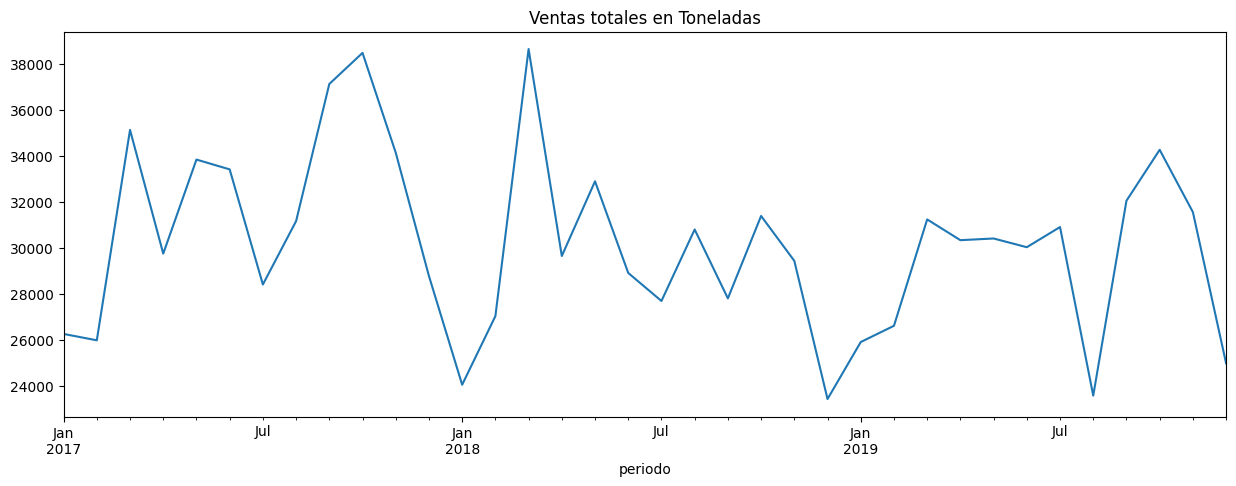

In [19]:
print('Dataframe raw:', data.shape)

###########################################################################
# Parametros Generales

# Indica como hace el corte de los datos en Train, Valod y Test
# Importante para que no pinche el EarlyStop de mi Red
pipeline_type = 'Kaggle' # Kaggle: 2019-10 | Local: 2019-12

# Instancia, si se corre en mas de una maquina a lavez
instance = "A"

# Cuantas unidades de tiempo hacia atras usamos para crear el Windowed Dataframe
window_size = 3 # Probar con 6 tambien

# Predecimos el mes +2, osea 2019-12 (Local) o 2020-02 (Kaggle)
horizon = 2

# Batch size para el entrenamiento del modelo
batch_size = 32

# Tipo de Scaler
normalization = "MinMax"
###########################################################################
# Filtros Iniciales

# Solo tenemos en cuenta los 780 productos a predecir
data =filter_products_data(data, data_productos_a_predecir)
print('Filtro Productos a Predecir:', data.shape)


# Si quiero solo las ventas de los clientes activos
data = filter_active_clients_data(data)
print('Filtro Clientes Activos:', data.shape)


# Ploteamos para ver como quedan las ventas totales acumuladas
group_data(data, 'product_id').sum(axis=1).plot(figsize=(15, 5))
plt.title('Ventas totales en Toneladas')
plt.show()
###########################################################################
# Decomisionado

# # # ACTUALIZAR
# data = fix_holes(data) # Falta vacios al principioy final
# print(data.shape)

# # # ACTUALIZAR
# # Estrategia para completar los NaN de los datos agrupados
# # data_grouped = fill_nulls(data_grouped)

# # Estrategia para solucionar el problema de Agosto 2019
# data = fix_aug2019(data, 'julplus10')
###########################################################################

# Hago un backup del Dataframe con los filtrados que quiero
data_filtered = data.copy()

## Generador de Predicciones

In [20]:
# # En esta celda estsa todo el codigo que utilizamos para la generacion de nuestras predicciones
# # Deberiamos haber utilizado distintas semillas, para haber facilitado mas la reproducibilidad del experimento
# # Indicar el product_id de inicio y de fin, y generara al menos un archivo con las predicciones para ese rango


# # Acotamos el bucle, solo los productos que nos interesa
# product_id_start = '21086'
# product_id_end = '21276'
# start_index = data_productos_a_predecir.index.get_loc(product_id_start)
# end_index = data_productos_a_predecir.index.get_loc(product_id_end) + 1  # +1 to include the end inde


# # Inicializamos Dataframe de Predicciones
# product_predictions = data_productos_a_predecir.copy()
# product_predictions['Real'] = None
# product_predictions['MinMax'] = None
# product_predictions['Robust'] = None

# # Bucle principal de Productos
# for producto in data_productos_a_predecir.index[start_index:end_index]:
#   # Busco el valor real de Dec 2019 en mi Dataframe original
#   print('Producto:', producto)
#   valor_dec_19 = group_data(data_bkp.query('periodo == "2019-12-01"'), 'product_id')[producto].values[0]
#   product_predictions.loc[producto, 'Real'] = valor_dec_19

#   # Filtro por producto
#   data_product = data.query("product_id == @producto")
#   # display(data_product.tail())

#   # Agrupo el Dataframe
#   data_grouped = group_data(data_product, 'product_id')

#   # Arreglo fechas en productos jovenes, o discontinuados
#   data_grouped = fill_missing_dates(data_grouped, pipeline_type)

#   # Arreglo Agosto 2019
#   data_grouped = fix_aug2019(data_grouped, 'mean')

#   # Generacion de variables adicionales
#   data_grouped = feature_engineering(data_grouped)
#   # display(data_grouped)

#   # Cant de veces que se repite cada experimento con los mismos parametros, pero sin semilla
#   n = 3

#   # Split. No pude hacer funcionar el TimeSeriesSplit
#   data_train, data_valid = split_data_fe(data_grouped, window_size, horizon)
#   # display(data_train)
#   # display(data_valid)

#   # Generamos predicciones, pero utilizando dos Normalizadores distintos
#   ##########################################################################
#   # Robust Scaler primero

#   print('Robust')
#   scaler = RobustScaler() # Probar con transformaciones no-lineales
#   data_train_norm = pd.DataFrame(scaler.fit_transform(data_train), columns=data_train.columns, index=data_train.index)
#   data_valid_norm = pd.DataFrame(scaler.transform(data_valid), columns=data_valid.columns, index=data_valid.index)

#   predictions_list = []

#   for i in range(n):
#     # Creo los Windowed Datasets
#     data_train_windowed = windowed_dataset(data_train_norm, data_split='train', window_size=window_size, horizon=horizon, batch_size=batch_size)
#     data_valid_windowed = windowed_dataset(data_valid_norm, data_split='valid', window_size=window_size, horizon=horizon, batch_size=batch_size)

#     # Parmetros del modelo
#     loss = 'mse'
#     optimizer = 'adam'
#     patience = 20
#     epochs = 500
#     n_features = data_train.shape[1]
#     callbacks = MyCallbacks(patience)

#     # Modelo
#     model = MyModel(loss, optimizer, window_size, horizon, n_features)
#     history = model.fit(
#         data_train_windowed,
#         validation_data=data_valid_windowed,
#         callbacks=callbacks,
#         verbose=0,
#         epochs=epochs
#     )
#     # plot_history(history) # Visualizamos el entrenamiento del modelo

#     # # Para ver como esta compuesto el vector de predicciones
#     # print(generate_predictions(model, data_valid_norm, scaler))

#     # Genero la prediccion, y la agrego al vector
#     prediction = generate_predictions(model, data_valid_norm, scaler)[0]
#     predictions_list.append(prediction)

#     # Liberar memoria
#     del model
#     del data_train_windowed
#     del data_valid_windowed
#     clear_session()
#     gc.collect()


#   # display(data_grouped.loc['2019-12'])
#   # print('¨Prediccion:', np.mean(predictions_list))
#   product_predictions.loc[producto, 'Robust'] = np.mean(predictions_list)
#   ##########################################################################
#   # MinMax Scaler segundo

#   print('MinMax')
#   scaler = MinMaxScaler() # Probar con transformaciones no-lineales
#   data_train_norm = pd.DataFrame(scaler.fit_transform(data_train), columns=data_train.columns, index=data_train.index)
#   data_valid_norm = pd.DataFrame(scaler.transform(data_valid), columns=data_valid.columns, index=data_valid.index)

#   predictions_list = []

#   for i in range(n):
#     # Creo los Windowed Datasets
#     data_train_windowed = windowed_dataset(data_train_norm, data_split='train', window_size=window_size, horizon=horizon, batch_size=batch_size)
#     data_valid_windowed = windowed_dataset(data_valid_norm, data_split='valid', window_size=window_size, horizon=horizon, batch_size=batch_size)

#     # Parmetros del modelo
#     loss = 'mse'
#     optimizer = 'adam'
#     patience = 20
#     epochs = 500
#     n_features = data_train.shape[1]
#     callbacks = MyCallbacks(patience)

#     # Modelo
#     model = MyModel(loss, optimizer, window_size, horizon, n_features)
#     history = model.fit(
#         data_train_windowed,
#         validation_data=data_valid_windowed,
#         callbacks=callbacks,
#         verbose=0, # Poner en 0 si se hacen bucles largos
#         epochs=epochs
#     )
#     # plot_history(history)

#     # # Para ver como esta compuesto el vector de predicciones
#     # print(generate_predictions(model, data_valid_norm, scaler))

#     # Genero la prediccion, y la agrego al vector
#     prediction = generate_predictions(model, data_valid_norm, scaler)[0]
#     predictions_list.append(prediction)

#     # Liberar memoria
#     del model
#     del data_train_windowed
#     del data_valid_windowed
#     clear_session()
#     gc.collect()

#   # display(data_grouped.loc['2019-12'])
#   # print('¨Prediccion:', np.mean(predictions_list))
#   product_predictions.loc[producto, 'MinMax'] = np.mean(predictions_list)

#   # Exporta solo cuando el ultimo digito del ultimo producto coincide con el que ultimo del producto actual
#   # Para no exportar con cada producto, esto exporta 1 cada ~10
#   if producto[-1] == product_id_end[-1]:
#     filename = f"{instance}_Win{window_size}_{producto}.csv"
#     product_predictions.to_csv(path_data + filename)

#   # Si es para predecir Dec 19, los muestro
#   if pipeline_type == "Local":
#     display(product_predictions.loc[producto].to_frame().T)

# Experimentos Individuales

### 07/13 - Feature Engineering (Campo Antiguedad)

In [21]:
# # Agregado en la funcion de Feature Engineering

# product_id = '20032'  # Probar como ejemplos 20001 y 20032
# data_grouped = group_data(data.query("product_id == @product_id"), 'product_id')

# # Arreglo fechas en productos jovenes, o discontinuados
# data_grouped = fill_missing_dates(data_grouped, pipeline_type)

# # Arreglo Agosto 2019
# data_grouped = fix_aug2019(data_grouped, 'mean')

# antiguedad_inicial = 12 # A los 12 meses de exposicion, un producto ya puede considerarse maduro
# # antiguedad_inicial = df.shape[0]
# num_total_elements = len(data_grouped[product_id])
# num_unique_elements = data_grouped[product_id].nunique()

# if num_total_elements == num_unique_elements:
#   print("Todos los elementos de la columna 'producto' son distintos.")
#   data_grouped['old'] = np.arange(antiguedad_inicial, antiguedad_inicial + data_grouped.shape[0])
# else:
#   print("No todos los elementos de la columna 'producto' son distintos.")
#   serie = data_grouped[product_id]
#   duplicados = serie.duplicated()
#   ultima_posicion_duplicada = np.where(duplicados)[0][-1]
#   data_grouped['old'] = 0
#   n = data_grouped.shape[0] - ultima_posicion_duplicada
#   for i in range(n):
#       data_grouped.iloc[ultima_posicion_duplicada + i, data_grouped.columns.get_loc('old')] = i
# display(data_grouped)
#     # print(f"La ultima posición con un valor duplicado es: {ultima_posicion_duplicada}")


### 07/10 - Entrenamiento de Productos Hermanos

In [22]:
# # Seleccionamos uno o varios productos, y observamos sus categorias y productos hermanos
# # Productos hermanos = Cat1 = Cat2 = Cat3 = brand

# product_id_start = '20112'
# product_id_end = '20112'
# start_index = data_productos_a_predecir.index.get_loc(product_id_start)
# end_index = data_productos_a_predecir.index.get_loc(product_id_end) + 1  # +1 to include the end index

# for producto in data_productos_a_predecir.index[start_index:end_index]:

#   # Ploteamos la serie dle producto, y comparamos el valor real con las predicciones con scalers MinMax y Robust a Dec2019
#   plot_product(data, producto, pipeline_type)

#   # Extraigo y muestro los productos hermanos, para futuro analisis
#   # Esto puede servir para entrenar varios modelos, agrupados por productos hermanos
#   productos_hermanos = filter_productos_hermanos(data, producto)

In [23]:
# # Ploteamos las series de productos hermanos en una sola grafica

# # Me quedo solo con los productos hermanos
# filtered_data = data[data['product_id'].isin(productos_hermanos.index)]

# # Agrupo
# data_grouped = group_data(filtered_data, 'product_id')

# # Arreglo fechas en productos jovenes, o discontinuados
# data_grouped = fill_missing_dates(data_grouped, pipeline_type)

# # Arreglo Agosto 2019
# data_grouped = fix_aug2019(data_grouped, 'mean')

# # Grafico
# data_grouped.plot(figsize=(10, 5))
# plt.show()

# # Verificamos como se KNNImputer maneja los nulos
# display(data_grouped.head())

In [24]:
# # Realizo una prediccion naif de todos los productos hermanos juntos, para ver si la red toma las relaciones entre ellos

# window_size = 3

# # Split
# data_train, data_valid = split_data_fe(data_grouped, window_size, horizon)

# # Escalo
# scaler = MinMaxScaler() # RobustScaler
# data_train_norm = pd.DataFrame(scaler.fit_transform(data_train), columns=data_train.columns, index=data_train.index)
# data_valid_norm = pd.DataFrame(scaler.transform(data_valid), columns=data_valid.columns, index=data_valid.index)

# # Creo los Windowed Datasets
# data_train_windowed = windowed_dataset(data_train_norm, data_split='train', window_size=window_size, horizon=horizon, batch_size=batch_size)
# data_valid_windowed = windowed_dataset(data_valid_norm, data_split='valid', window_size=window_size, horizon=horizon, batch_size=batch_size)


# # Parmetros del modelo
# loss = 'mse'
# optimizer = 'adam'
# patience = 20
# epochs = 500
# n_features = data_train.shape[1]
# callbacks = MyCallbacks(patience)

# # Modelo
# model = MyModel(loss, optimizer, window_size, horizon, n_features)
# history = model.fit(
#     data_train_windowed,
#     validation_data=data_valid_windowed,
#     callbacks=callbacks,
#     verbose=0, # Poner en 0 si se hacen bucles largos
#     epochs=epochs
# )
# plot_history(history)

# print(generate_predictions(model, data_valid_norm, scaler))

In [25]:
# # Grafico cada producto hermano por separado, para verificar valores atipicos e intentar otros approaches
# # Verifico si me combiene cambiar el scaler, o usar on horizon distinto si es que observo estacionariedades

# product = '20002'
# data_grouped[product].plot(figsize=(14, 5))
# plt.title(f'Producto {product}')
# plt.show()


In [26]:
# # Probamos con distintas estrategias para cada producto individual
# # Podemos cambiar el window_size,  el scaler, y la cantidad de iteraciones, para ver como se comprotan las predicciones

# scaler_type = 'MinMax'
# window_size = 3
# n = 1

# data_product = data.query("product_id == @producto")
# data_product_grouped = group_data(data_product, 'product_id')
# display(data_product_grouped.head())
# display(data_product_grouped.tail())

# # # Esto no deberia de ser necesario
# # data_product_grouped = fill_missing_dates(data_product_grouped)
# # # data_product_grouped = fix_aug2019(data_product_grouped, 'mean')

# data_product_grouped_fe = feature_engineering(data_product_grouped)

# # # Split. No pude hacer funcionar el TimeSeriesSplit
# data_train, data_valid = split_data_fe(data_product_grouped_fe, window_size, horizon)

# # Escalo
# if scaler_type=='MinMax':
#   scaler = MinMaxScaler() # RobustScaler
# elif scaler_type=='Robust':
#   scaler = RobustScaler()
# else:
#   raise ValueError("Invalid scaler type")
# data_train_norm = pd.DataFrame(scaler.fit_transform(data_train), columns=data_train.columns, index=data_train.index)
# data_valid_norm = pd.DataFrame(scaler.transform(data_valid), columns=data_valid.columns, index=data_valid.index)

# predictions_list = []

# for i in range(n):

#   # Creo los Windowed Datasets
#   data_train_windowed = windowed_dataset(data_train_norm, data_split='train', window_size=window_size, horizon=horizon, batch_size=batch_size)
#   data_valid_windowed = windowed_dataset(data_valid_norm, data_split='valid', window_size=window_size, horizon=horizon, batch_size=batch_size)
#   n_features = data_train.shape[1]

#   # Parmetros del modelo
#   loss = 'mse'
#   optimizer = 'adam'
#   patience = 20
#   epochs = 500
#   n_features = data_train.shape[1]
#   callbacks = MyCallbacks(patience)

#   # Modelo
#   model = MyModel(loss, optimizer, window_size, horizon, n_features)
#   history = model.fit(
#       data_train_windowed,
#       validation_data=data_valid_windowed,
#       callbacks=callbacks,
#       verbose=0, # Poner en 0 si se hacen bucles largos
#       epochs=epochs
#   )
#   plot_history(history)

#   # Genero la prediccion, y la agrego al vector
#   prediction = generate_predictions(model, data_valid_norm, scaler)[1]
#   predictions_list.append(prediction)

# print('Producto:', producto, '\n')
# print('¨Prediccion:', np.mean(predictions_list))
# print(f'Scaler {scaler_type}, Window_size {window_size}')

### 07/09 - Feature Engineering (A manopla)

In [27]:
# # Selecciono un producto
# product = '20334'
# data_product = data.query("product_id == @product")
# data_grouped = group_data(data_product, 'product_id')
# data_grouped = fix_aug2019(data_grouped, 'mean')
# data_grouped.index.name = 'periodo'

# # Genero el grouped Dataframe, crea los index faltantes, y "maneja" los nulos
# data_grouped = fill_missing_dates(data_grouped, pipeline_type)

# # Generacion de variables adicionales
# data_grouped = feature_engineering(data_grouped)

# # Split. No pude hacer funcionar el TimeSeriesSplit
# data_train, data_valid = split_data_fe(data_grouped, window_size, horizon)

# # Escalo
# scaler = MinMaxScaler() # RobustScaler
# data_train_norm = pd.DataFrame(scaler.fit_transform(data_train), columns=data_train.columns, index=data_train.index)
# data_valid_norm = pd.DataFrame(scaler.transform(data_valid), columns=data_valid.columns, index=data_valid.index)

# # Creo los Windowed Datasets
# data_train_windowed = windowed_dataset(data_train_norm, data_split='train', window_size=window_size, horizon=horizon, batch_size=batch_size)
# data_valid_windowed = windowed_dataset(data_valid_norm, data_split='valid', window_size=window_size, horizon=horizon, batch_size=batch_size)


# # Parmetros del modelo
# loss = 'mse'
# optimizer = 'adam'
# patience = 20
# epochs = 500
# n_features = data_train.shape[1]
# callbacks = MyCallbacks(patience)

# # Modelo
# model = MyModel(loss, optimizer, window_size, horizon, n_features)
# history = model.fit(
#     data_train_windowed,
#     validation_data=data_valid_windowed,
#     callbacks=callbacks,
#     verbose=0, # Poner en 0 si se hacen bucles largos
#     epochs=epochs
# )
# plot_history(history)

# generate_predictions(model, data_valid_norm, scaler)[0]

### 07/08 - Feature Engineering (Featuretools). Muy complicado

In [28]:
# !pip install featuretools
# import featuretools as ft
# from featuretools.demo import load_weather
# from featuretools.primitives import Lag, RollingMean, RollingMin
# from featuretools.primitives import Lag, RollingMean, RollingMin



# # Asegúrate de que data_grouped esté definido antes de este punto.
# product = '20012'
# data_product = data.query("product_id == @product")
# data_grouped = group_data(data_product, 'product_id')
# data_grouped = fix_aug2019(data_grouped, 'mean')
# data_grouped.reset_index(inplace=True)
# data_grouped.rename(columns={'index': 'periodo'}, inplace=True)

# # Configuración para lags y rolling por 12 meses
# window_length = window_size
# gap = horizon



# es = ft.EntitySet(id="sales_data")

# es = es.add_dataframe(dataframe_name="sales",
#                       dataframe=data_grouped,
#                       index="index",
#                       time_index="periodo")

# datetime_primitives = ["Year",  "Month"]

# delaying_primitives = [Lag(periods=i + gap) for i in range(window_length)]

# rolling_mean_primitive = RollingMean(
#     window_length=window_length, gap=gap, min_periods=window_length)

# rolling_min_primitive = RollingMin(
#     window_length=window_length, gap=gap, min_periods=window_length)


# data_fe, _ = ft.dfs(
#     entityset=es,
#     target_dataframe_name="sales",
#     trans_primitives=(
#         # datetime_primitives +
#          delaying_primitives
#         + [rolling_mean_primitive, rolling_min_primitive]
#     ),
#     # cutoff_time=pd.Timestamp("2019-03-01"),
# )
# data_fe.dropna(inplace=False)

# data_fe.head()

In [29]:
# data_grouped = data_fe.dropna()

# data_train, data_valid = split_data_fe(data_grouped, window_size, horizon)

# # Ojo aca, que estoy escalando mes y ano
# scaler = MinMaxScaler()
# data_train_norm = pd.DataFrame(scaler.fit_transform(data_train), columns=data_train.columns, index=data_train.index)
# data_valid_norm = pd.DataFrame(scaler.transform(data_valid), columns=data_valid.columns, index=data_valid.index)

# # Creo los Windowed Datasets
# data_train_windowed = windowed_dataset(data_train_norm, data_split='train', window_size=window_size, horizon=horizon, batch_size=batch_size)
# data_valid_windowed = windowed_dataset(data_valid_norm, data_split='valid', window_size=window_size, horizon=horizon, batch_size=batch_size)


# # Parmetros del modelo
# loss = 'mse'
# optimizer = 'adam'
# patience = 30
# epochs = 500
# n_features = data_train.shape[1]
# callbacks = MyCallbacks(patience)

# # Modelo
# model = MyModel(loss, optimizer, window_size, horizon, n_features)
# history = model.fit(
#     data_train_windowed,
#     validation_data=data_valid_windowed,
#     callbacks=callbacks,
#     verbose=0, # Poner en 0 si se hacen bucles largos
#     epochs=epochs
# )
# plot_history(history)

# generate_predictions(model, data_valid_norm, scaler)

### 07/08 - Productos con malas predicciones

In [30]:
# data_predicciones_dec2019.head()

In [31]:
# # Acotamos el bucle, solo los productos que nos interesa
# product_id_start = '20001'
# product_id_end = '20001'
# start_index = data_productos_a_predecir.index.get_loc(product_id_start)
# # end_index = data_productos_a_predecir.index.get_loc(product_id_end) + 1  # +1 to include the end index

# for producto in data_productos_a_predecir.index[start_index:end_index]:
#   plot_product(data, producto, pipeline_type)
#   filter_productos_hermanos(data, producto)


# # Esto puede servir para entrenar varios modelos, agrupados por productos hermanos

### 07/07 - Por Cliente GENERAL

In [32]:
# # Inicializamos Dataframe de Predicciones
# product_predictions = data_productos_a_predecir.copy()
# product_predictions['Real'] = None
# product_predictions['MinMax'] = None
# product_predictions['Robust'] = None

# # Acotamos el bucle, solo los productos que nos interesa
# product_id_start = '20008'
# product_id_end = '20008'
# start_index = data_productos_a_predecir.index.get_loc(product_id_start)
# end_index = data_productos_a_predecir.index.get_loc(product_id_end) + 1  # +1 to include the end index

# for producto in data_productos_a_predecir.index[start_index:end_index]:
#   print('Producto:', producto)
#   # En caso de que quiera ver un producto en particular
#   data_product = data.query("product_id == @producto")

#   # Agrupo el Dataframe
#   data_grouped = group_data(data_product, 'product_id')
#   product_predictions.loc[producto, 'Real'] = data_grouped.loc['2019-12'].values

#   # Arreglo fechas en productos jovenes, o discontinuados
#   data_grouped = fill_missing_dates(data_grouped, pipeline_type)

#   # Modelo naif, asi que llenamos con bfill para atrasm y 0 para adelante
#   data_grouped.bfill(inplace=True)
#   data_grouped.fillna(0, inplace=True)

#   # Arreglo Agosto 2019
#   data_grouped = fix_aug2019(data_grouped, 'mean')
#   # display(data_grouped)

#   # Parametros para el Data Preprocessing
#   n = 3
#   horizon = 2
#   window_size = 6
#   batch_size = 32

#   # Separo en Train y Test. Split para Feb2020, Split2 para Dic2019
#   data_train, data_valid, data_test = split_data_dec2019(data_grouped, window_size)

In [33]:
  # # Genero n predicciones usando RobustScaler como normalizador, y despues las promedio
  # ##########################################################################
  # # Robust Scaler primero
  # print('Robust')
  # scaler = RobustScaler() # Probar con transformaciones no-lineales
  # data_train_norm = pd.DataFrame(scaler.fit_transform(data_train), columns=data_train.columns, index=data_train.index)
  # data_valid_norm = pd.DataFrame(scaler.transform(data_valid), columns=data_valid.columns, index=data_valid.index)
  # # data_test_norm = pd.DataFrame(scaler.transform(data_test), columns=data_test.columns, index=data_test.index)

  # predictions_list = []

  # for i in range(n):
  #   # Creo los Windowed Datasets
  #   data_train_windowed = windowed_dataset(data_train_norm, data_split='train', window_size=window_size, horizon=horizon, batch_size=batch_size)
  #   data_valid_windowed = windowed_dataset(data_valid_norm, data_split='valid', window_size=window_size, horizon=horizon, batch_size=batch_size)

  #   # Parmetros del modelo
  #   loss = 'mse'
  #   optimizer = 'adam'
  #   patience = 20
  #   epochs = 500
  #   n_features = data_train.shape[1]
  #   callbacks = MyCallbacks(patience)

  #   # Modelo
  #   model = MyModel(loss, optimizer, window_size, horizon, n_features)
  #   history = model.fit(
  #       data_train_windowed,
  #       validation_data=data_valid_windowed,
  #       callbacks=callbacks,
  #       verbose=0, # Poner en 0 si se hacen bucles largos
  #       epochs=epochs
  #   )
  #   plot_history(history) # Comentar si se hacen bucles largos

  #   # Genero la prediccion, y la agrego al vector
  #   prediction = generate_predictions(model, data_valid_norm, scaler)
  #   predictions_list.append(prediction)

  #   # Liberar memoria
  #   del model
  #   del data_train_windowed
  #   del data_valid_windowed
  #   clear_session()
  #   gc.collect()

  # # display(data_grouped.loc['2019-12'])
  # # print('¨Prediccion:', np.mean(predictions_list))
  # product_predictions.loc[producto, 'Robust'] = np.mean(predictions_list)

In [34]:
  # # Lo mismo pero con MinMax Scaler
  # ##########################################################################
  # # MinMax Scaler segundo
  # print('MinMax')
  # scaler = MinMaxScaler() # Probar con transformaciones no-lineales
  # data_train_norm = pd.DataFrame(scaler.fit_transform(data_train), columns=data_train.columns, index=data_train.index)
  # data_valid_norm = pd.DataFrame(scaler.transform(data_valid), columns=data_valid.columns, index=data_valid.index)
  # # data_test_norm = pd.DataFrame(scaler.transform(data_test), columns=data_test.columns, index=data_test.index) # No lo usamos

  # predictions_list = []

  # for i in range(n):
  #   # Creo los Windowed Datasets
  #   data_train_windowed = windowed_dataset(data_train_norm, data_split='train', window_size=window_size, horizon=horizon, batch_size=batch_size)
  #   data_valid_windowed = windowed_dataset(data_valid_norm, data_split='valid', window_size=window_size, horizon=horizon, batch_size=batch_size)

  #   # Parmetros del modelo
  #   loss = 'mse'
  #   optimizer = 'adam'
  #   patience = 20
  #   epochs = 500
  #   n_features = data_train.shape[1]
  #   callbacks = MyCallbacks(patience)

  #   # Modelo
  #   model = MyModel(loss, optimizer, window_size, horizon, n_features)
  #   history = model.fit(
  #       data_train_windowed,
  #       validation_data=data_valid_windowed,
  #       callbacks=callbacks,
  #       verbose=1, # Poner en 0 si se hacen bucles largos
  #       epochs=epochs
  #   )
  #   plot_history(history)

  #   # Genero la prediccion, y la agrego al vector
  #   prediction = generate_predictions(model, data_valid_norm, scaler)
  #   predictions_list.append(prediction)

  #   # Liberar memoria
  #   del model
  #   del data_train_windowed
  #   del data_valid_windowed
  #   clear_session()
  #   gc.collect()

  # # display(data_grouped.loc['2019-12'])
  # # print('¨Prediccion:', np.mean(predictions_list))
  # product_predictions.loc[producto, 'MinMax'] = np.mean(predictions_list)

  # # # Exporta solo cuando el ultimo digito del ultimo producto coincide con el que ultimo del producto actual
  # # # Para no exportar con cada producto, esto exporta 1 cada 10
  # # if producto[-1] == product_id_end[-1]:
  # #   filename = f"{producto}.csv"
  # #   product_predictions.to_csv(path_data + filename)

  # display(product_predictions.loc[producto].to_frame().T)

### 07/07 - Walk-Forward Validation (TimeSeriesSplit)

In [35]:
# # OJO QUE PUEDE FUNCIONAR, PROBAR DESPUES
# # Se rompe el EarlyStopping, pero corre
# # No lo pudimos hacer funcionar, asi que no continuamos con esta idea
# # Pero esto junto con mejorar el FE seria lo primero a resolver en futuras iteraciones

# n_splits = 3
# n = 3 # Cantidad de experimentos por split

# # Genero un backup del Dataframe sin agrupar
# data = data_bkp.copy()

# # En caso de que quiera ver un producto en particular
# producto = '20001'
# data_product = data.query("product_id == @producto")

# # Agrupo el Dataframe
# data_grouped = group_data(data_product, 'product_id')

# # Modelo naif, así que llenamos con bfill para atrás, y 0 para adelante
# data_grouped.bfill(inplace=True)
# data_grouped.fillna(0, inplace=True)

# # Arreglo Agosto 2019
# data_grouped = fix_aug2019(data_grouped, 'mean')

# # Parámetros para el Data Preprocessing
# horizon = 2
# batch_size = 32
# seed = 151
# window_size = 3

# # Separo en Train y Test usando TimeSeriesSplit
# splits = split_data_timeseriessplit(data_grouped, n_splits)

# # Normalizo
# scaler = MinMaxScaler() # Probar con StandardScaler
# data_grouped_norm = pd.DataFrame(scaler.fit_transform(data_grouped), columns=data_grouped.columns, index=data_grouped.index)

# predictions_list = []

# for train_index, test_index in splits:
#     df_train = data_grouped_norm.iloc[train_index]
#     df_test = data_grouped_norm.iloc[test_index]
#     # Ajustar para asegurar suficientes datos en validación
#     df_valid = df_test.iloc[:int(len(df_test) * 0.7)]  # Aumenta el tamaño del conjunto de validación
#     df_test = df_test.iloc[int(len(df_test) * 0.7):]  # Reduce el tamaño del conjunto de prueba

#     for i in range(n):
#         # Creo los Windowed Datasets
#         data_train_windowed = windowed_dataset(df_train, data_split='train', window_size=window_size, horizon=horizon, batch_size=batch_size)
#         data_valid_windowed = windowed_dataset(df_valid, data_split='valid', window_size=window_size, horizon=horizon, batch_size=batch_size)

#         # Parámetros del modelo
#         loss = 'mse'
#         optimizer = 'adam'
#         patience = 5
#         epochs = 10 # Segun el valor del window_size, se rompe el EarlyStopping. Hay que poner un valor bajo en epochs
#         n_features = df_train.shape[1]
#         callbacks = MyCallbacks(patience) # Ojo con el window_size

#         # Modelo
#         model = MyModel(loss, optimizer, window_size, horizon, n_features)
#         history = model.fit(
#             data_train_windowed,
#             validation_data=data_valid_windowed,
#             callbacks=callbacks,
#             verbose=0,
#             epochs=epochs
#         )

#         # Genero la predicción, y la agrego al vector
#         prediction = generate_predictions(model, df_valid, scaler)
#         predictions_list.append(prediction)

#         # Liberar memoria
#         del model
#         del data_train_windowed
#         del data_valid_windowed
#         clear_session()
#         gc.collect()

# display(f'Producto {producto}:', np.mean(predictions_list))

### 06/30 - Por Cliente, Producto, Cat1, Cat2

In [36]:
# index_start = 471
# index_end = None

# horizon = 2
# window_size = 6
# batch_size = 32

# customers = group_data(data, 'customer_id').loc['2019'].sum().index

# # Corte por Cliente
# for customer in customers[index_start:index_end]:

#     # Inicializo el Dataframe con las ventas del cliente
#     predicciones_by_customer = data_productos_a_predecir.copy()
#     predicciones_by_customer['tn'] = 0
#     predicciones_by_customer_serie = predicciones_by_customer.squeeze()

#     # Filtro el DataFrame con solo las ventas del Cliente
#     data_customer = data.loc[data['customer_id'] == customer]

#     # Corte por Cat1
#     for cat1 in data_customer['cat1'].unique():
#       # Corte por Cat2
#       for cat2 in data_customer.loc[data_customer['cat1'] == cat1]['cat2'].unique():
#         print(customer, cat1, cat2)

#         # Filtro el DataFrame por Cat1 y Cat2
#         data_customer_cat1_cat2 = data_customer.loc[(data_customer['cat1'] == cat1) & (data_customer['cat2'] == cat2)]

#         # Agrupo los datos filtrados Cliente, Cat1, Cat2
#         gruoped_data = group_data(data_customer_cat1_cat2, 'product_id')

#         # Para los meses sin venta en los datos agrupados, los completo con NaN
#         gruoped_data = fix_grouped_data(gruoped_data)

#         # Fill los meses con NaN
#         gruoped_data = fill_nulls(gruoped_data)

#         # Arreglo Agosto 2019
#         grouped_data = fix_aug2019(gruoped_data, 'mean')

#         # Separo en Train y Test, aca hay que jugar con TimeSeriesSplit
#         data_train, data_valid = split_data(grouped_data, window_size)
#         # print(data_train.shape, data_valid.shape)

#         # Normalizo
#         scaler = MinMaxScaler() # Probar con StandardScaler
#         data_train = pd.DataFrame(scaler.fit_transform(data_train), columns=data_train.columns, index=data_train.index)
#         data_valid = pd.DataFrame(scaler.transform(data_valid), columns=data_valid.columns, index=data_valid.index)

#         # Creo los Windowed Datasets
#         data_train_windowed = windowed_dataset(data_train, data_split='train', window_size=window_size, horizon=horizon, batch_size=batch_size)
#         data_valid_windowed = windowed_dataset(data_valid, data_split='valid', window_size=window_size, horizon=horizon, batch_size=batch_size)

#         # Parmetros del modelo
#         loss = 'mse'
#         optimizer = 'adam'
#         patience = 30
#         epochs = 500
#         n_features = data_train.shape[1]
#         callbacks = MyCallbacks(patience)

#         model = MyModel(loss, optimizer, window_size, horizon, n_features)
#         history = model.fit(
#             data_train_windowed,
#             validation_data=data_valid_windowed,
#             callbacks=callbacks,
#             verbose=0,
#             epochs=epochs
#         )

#         plot_history(history)

#         #generate_predictions_6(model_trained, data_valid, scaler):

#         predictions = generate_predictions(model, data_valid, scaler)
#         predicciones_by_customer_serie = sumar_series(predicciones_by_customer_serie, predictions)

#         # Liberar memoria
#         del model
#         del data_train
#         del data_valid
#         del data_train_windowed
#         del data_valid_windowed
#         clear_session()
#         gc.collect()

#     filename = f"{customer}.csv"
#     predicciones_by_customer_serie.to_csv(path_data + filename)

### 06/29 - Predicciones por Cliente


In [37]:
# Funciones para el manejo de archivos

# Que predicciones me falta calcular
# check_preddictions_files(path_data + 'Predicciones_cat1_cat2//')

# Genera un unico archivo de predicciones, concatenando las predicciones indifiduales
# predictions = generate_predictions_from_files(path_predicciones)

# to_kaggle_2(predictions.sum(axis=1).sort_index(), "por_cliente_win6")

### 06/25 - Categorias Extendidas

In [38]:

# customers = group_data(data, 'customer_id').loc['2019'].sum().index

# for customer in customers[0:]:
#     predicciones_by_customer = data_productos_a_predecir.copy()
#     predicciones_by_customer['tn'] = 0
#     predicciones_by_customer_serie = predicciones_by_customer.squeeze()

#     data_customer = data.loc[data['customer_id'] == customer]
#     for customer_cat1 in data_customer['cat1'].unique():
#         for customer_cat1_cat2 in data_customer.loc[data_customer['cat1'] == customer_cat1]['cat2'].unique():
#             for customer_cat1_cat2_cat3 in data_customer.loc[(data_customer['cat1'] == customer_cat1) & (data_customer['cat2'] == customer_cat1_cat2)]['cat3'].unique():
#                 data_customer_cat1_cat2_cat3 = data_customer.loc[(data_customer['cat1'] == customer_cat1) & (data_customer['cat2'] == customer_cat1_cat2) & (data_customer['cat3'] == customer_cat1_cat2_cat3)]
#                 data_customer_cat1_cat2_cat3_grouped = group_data(data_customer_cat1_cat2_cat3, 'product_id')
#                 data_customer_cat1_cat2_cat3_grouped_fillna = fill_nulls(data_customer_cat1_cat2_cat3_grouped)
#                 # data_customer_cat1_cat2_cat3_grouped_fillna_fixaug2019 = fix_aug2019(data_customer_cat1_cat2_cat3_grouped_fillna, 'julplus10') # ojo con esto

#                 split_strategy = 'S1'
#                 normalization = 'MinMax'
#                 horizon = 2
#                 window_size = 6
#                 batch_size = 32

#                 data_train, data_valid = split_data(data_customer_cat1_cat2_cat3_grouped_fillna, window_size)
#                 print(f'{customer}, {customer_cat1}, {customer_cat1_cat2}, {customer_cat1_cat2_cat3}')
#                 print(data_train.shape[0], data_valid.shape[0])
#                 if data_train.shape[0] >= (horizon + window_size) and data_valid.shape[0] >= (horizon + window_size):
#                     data_train_norm, data_valid_norm, norm_params = normalize_data(data_train, data_valid, normalization)

#                     data_train_windowed = windowed_dataset(data_train_norm, data_split='train', window_size=window_size, horizon=horizon, batch_size=batch_size)
#                     data_valid_windowed = windowed_dataset(data_valid_norm, data_split='valid', window_size=window_size, horizon=horizon, batch_size=batch_size)

#                     model_name = 'M1'
#                     loss = 'mse'
#                     optimizer = 'adam'
#                     patience = 30
#                     epochs = 1000
#                     n_features = data_train.shape[1]

#                     callbacks = MyCallbacks(patience)
#                     model = MyModel(loss, optimizer, window_size, horizon, n_features)

#                     history = model.fit(
#                         data_train_windowed,
#                         validation_data=data_valid_windowed,
#                         callbacks=callbacks,
#                         verbose=0,
#                         epochs=epochs
#                     )

#                     # plot_history(history)

#                     predictions = generate_predictions_4(model, data_valid_norm, norm_params)
#                     predicciones_by_customer_serie = sumar_series(predicciones_by_customer_serie, predictions)

#                     # Liberar memoria
#                     del model
#                     del data_train
#                     del data_valid
#                     del data_train_windowed
#                     del data_valid_windowed
#                     clear_session()
#                     gc.collect()

#     filename = f"{customer}"
#     to_kaggle_2(predicciones_by_customer_serie, filename)
#     print(filename)


### 06/24 - Entrenamiento a 2018-05

In [39]:
# # Todos los productos
# data_201805 = data_extended.loc[:'2018-05']
# data_201807 = data_extended.loc['2018-07']

# # # Filtando por categorias
# # data_201805 = data_extended.loc[:'2018-05'].query('cat1 == "FOODS"') # PC, HC, FOODS
# # data_201807 = data_extended.loc['2018-07'].query('cat1 == "FOODS"') # PC, HC, FOODS

# print('Cantidad productos al 201805:', data_201805['product_id'].unique().shape)
# print('Cantidad productos en 201807:', data_201807['product_id'].unique().shape)

# ytrue = data_201807.groupby('product_id')['tn'].sum()
# # print(ytrue.head())

# data_201805_grouped = group_data(data_201805, 'product_id')
# data_201805_grouped_fillna = fill_nulls(data_201805_grouped)
# # display(data_201805_grouped_fillna)

# # Ojo que en Mayo tene,ps 976 prodictos, pero en Julio solo 846

In [40]:
# split_strategy = 'S1'
# normalization = 'MinMax'
# window_size = None
# horizon = 2
# batch_size = None


# # Model Variables: Dentro de cada Experimento, no son generales
# n_features = None  # Esto va a depender de cada modelo, es el data_train.shape[1]
# n_splits = None # No mas, la usabamos con el TimeSeriesSplit
# # model_name = 'CAT1'
# # loss = 'mse'
# # optimizer = 'adam'
# # patience = 30
# # epochs = 10


# window_size = 3
# batch_size = 32

# # Para el primer pipeline, entrenamiento correcto hasta 201805
# data_train, data_valid = split_data_201805(data_201805_grouped_fillna, window_size)

# data_train_norm, data_valid_norm, norm_params = normalize_data(data_train, data_valid, normalization)
# print(data_train_norm.shape)

# data_train_windowed = windowed_dataset(data_train_norm, data_split='train', window_size=window_size, horizon=horizon, batch_size=batch_size)
# data_valid_windowed = windowed_dataset(data_valid_norm, data_split='valid', window_size=window_size, horizon=horizon, batch_size=batch_size)


# # Model Variables
# model_name = 'M1'
# loss = 'mse'
# optimizer = 'adam'
# patience = 30
# epochs = 500
# n_features = data_train.shape[1]

# callbacks = MyCallbacks(patience)
# model = MyModel(loss, optimizer, window_size, horizon, n_features)

# history = model.fit(
#     data_train_windowed,
#     validation_data=data_valid_windowed,
#     callbacks=callbacks,
#     verbose=0,
#     epochs=epochs
#     )

# plot_history(history)
# predictions = generate_predictions_3(model, data_valid_norm, norm_params)

# # Filtrar para obtener solo los índices que están en ambas series
# common_indices = ytrue.index.intersection(predictions.index)

# # Crear un DataFrame concatenando las dos series usando solo los índices comunes
# predictions_df = pd.concat([ytrue[common_indices], predictions[common_indices]], axis=1)
# predictions_df.columns = ['true', 'predicted']

# calcular_error(predictions_df)

### 06/24 - Actividad en Clase: Entrenamiento con Datos del futuro (2018-07)

In [41]:
# # # OJO QUE ESTE ENTRENA HASTA 201807
# # # no le cambio los nombres a la variable para que sea mas sencillo de correr

# # Todos los productos
# data_201805 = data_extended.loc[:'2018-07']
# data_201807 = data_extended.loc['2018-07']

# # # Filtando por categorias
# # data_201805 = data_extended.loc[:'2018-07'].query('cat1 == "PC"') # PC, HC, FOODS
# # data_201807 = data_extended.loc['2018-07'].query('cat1 == "PC"') # PC, HC, FOODS

# print('Cantidad productos al 201805:', data_201805['product_id'].unique().shape)
# print('Cantidad productos en 201807:', data_201807['product_id'].unique().shape)

# ytrue = data_201807.groupby('product_id')['tn'].sum()
# # print(ytrue.head())

# data_201805_grouped = group_data(data_201805, 'product_id')
# data_201805_grouped_fillna = fill_nulls(data_201805_grouped)
# # display(data_201805_grouped_fillna)

# # Ojo que en Mayo tene,ps 976 prodictos, pero en Julio solo 846

In [42]:
# split_strategy = 'S1'
# normalization = 'MinMax'
# window_size = None
# horizon = 2
# batch_size = None


# # Model Variables: Dentro de cada Experimento, no son generales
# n_features = None  # Esto va a depender de cada modelo, es el data_train.shape[1]
# n_splits = None # No mas, la usabamos con el TimeSeriesSplit
# # model_name = 'CAT1'
# # loss = 'mse'
# # optimizer = 'adam'
# # patience = 30
# # epochs = 10



# window_size = 3
# batch_size = 32

# # Segudno Pipeline, validacion con datos del futuro hasta 201807
# data_train, data_valid = split_data_201807(data_201805_grouped_fillna, window_size)

# data_train_norm, data_valid_norm, norm_params = normalize_data(data_train, data_valid, normalization)
# print(data_train_norm.shape)

# data_train_windowed = windowed_dataset(data_train_norm, data_split='train', window_size=window_size, horizon=horizon, batch_size=batch_size)
# data_valid_windowed = windowed_dataset(data_valid_norm, data_split='valid', window_size=window_size, horizon=horizon, batch_size=batch_size)


# # Model Variables
# model_name = 'M1'
# loss = 'mse'
# optimizer = 'adam'
# patience = 30
# epochs = 500
# n_features = data_train.shape[1]

# callbacks = MyCallbacks(patience)
# model = MyModel(loss, optimizer, window_size, horizon, n_features)

# history = model.fit(
#     data_train_windowed,
#     validation_data=data_valid_windowed,
#     callbacks=callbacks,
#     verbose=0,
#     epochs=epochs
#     )

# plot_history(history)
# predictions = generate_predictions_3(model, data_valid_norm, norm_params)

# # Filtrar para obtener solo los índices que están en ambas series
# common_indices = ytrue.index.intersection(predictions.index)

# # Crear un DataFrame concatenando las dos series usando solo los índices comunes
# predictions_df = pd.concat([ytrue[common_indices], predictions[common_indices]], axis=1)
# predictions_df.columns = ['true', 'predicted']

# calcular_error(predictions_df)

### 06/20 - Prediccion de Producto, Multivariada por Clientes

In [43]:
# # Inicializamos el vector de predicciones
# vector_predictions = data_productos_a_predecir.copy()
# vector_predictions['tn'] = 0
# # vector_predictions['nulls'] = 0

# # Eliminamos los productos que no nos interesan
# data_products_filtered = filter_products_data(data_bkp, data_productos_a_predecir)

# # Iteramos por cada producto
# for product in data_productos_a_predecir.index[1:2]:
#   # print(f'Producto {product}')

#   data_product_grouped = group_data(data_products_filtered, 'customer_id')
#   # print(data_product_grouped.shape)

#   data_product_grouped_customer = data_product_grouped.columns
#   # print(data_product_grouped_customer)

#   # Inicializamos el vector predicciones por cliente, para ese producto
#   vector_clientes = pd.DataFrame(pd.Series(data_product_grouped_customer.copy(), name='customer'))
#   vector_clientes.set_index('customer', inplace=True)
#   vector_clientes['tn'] = 0
#   vector_clientes['nulls'] = 0

#   # print(vector_clientes.head())

#   # Recorremos las ventas de cada customer

#   for customer in data_product_grouped_customer[3:5]:
#     print(f'Producto {product}')
#     print(f'Customer {customer}')
#     data_product = data_product_grouped[customer].copy()
#     cant_nulos = data_product.isnull().sum()
#     data_product = data_product.to_frame()
#     data_product.fillna(0, inplace=True)
#     # print(data_product)


#     # Añadir indicador de disponibilidad al producto
#     # first_sale_date = data_product[data_product > 0].index[0]
#     data_product['available'] = (data_product > 0).astype(int)
#     # print(data_product)

#     # Jugamos con esto acá, para ver el tema de la validación en el entrenamiento
#     window_size = 6
#     batch_size = 1

#     data_train, data_valid = split_data(data_product, window_size)
#     data_train_norm, data_valid_norm, norm_params = normalize_data(data_train, data_valid, normalization)

#     # Convertir DataFrame a numpy array
#     train_sequence = data_train_norm.values
#     valid_sequence = data_valid_norm.values

#     data_train_windowed = windowed_dataset(train_sequence, data_split='train', window_size=window_size, horizon=horizon, batch_size=batch_size)
#     data_valid_windowed = windowed_dataset(valid_sequence, data_split='valid', window_size=window_size, horizon=horizon, batch_size=batch_size)


#       # Model Variables
#     model_name = 'xx'
#     loss = 'mse'
#     optimizer = 'adam'
#     patience = 30
#     epochs = 300
#     n_features = data_train.shape[1]

#     callbacks = MyCallbacks(patience)
#     model = MyModel(loss, optimizer, window_size, horizon, n_features)

#     history = model.fit(
#         data_train_windowed,
#         validation_data=data_valid_windowed,
#         callbacks=callbacks,
#         verbose=1,
#         epochs=epochs
#     )

#     plot_history(history)
#     predictions = generate_predictions_2(model, data_valid_norm, norm_params)

#     # Vamos sumando en el vector de acum
#     value_to_add = predictions.loc['2020-02'].values[0]
#     vector_clientes.loc[customer, 'nulls'] = cant_nulos
#     vector_clientes.loc[customer, 'tn'] += value_to_add
#     # print(vector_clientes)

#   # print(vector_predictions.head())
#   filename_cliente = f"{product}_win{window_size}.csv"
#   # print(filename)
#   vector_clientes.to_csv(filename_cliente, header=True, index=True)

#   vector_predictions.loc[product, 'tn'] += vector_clientes['tn'].sum()

# filename_predicciones = f"SumaPredicciones_win{window_size}.csv"
# # print(filename)
# vector_predictions.to_csv(filename_predicciones, header=True, index=True)


In [44]:
# # # Analizamos la prediccion de un producto en particular, generanzo una matriz multivariada con columnas por cliente

# # Producto 20001
# data_20001 = data_bkp.query('product_id == "20001"')[['customer_id', 'tn']].copy()

# print(data_20001.shape)
# display(data_20001.head())

# # plot_grouped_data_heatmap(data_20001, 'customer_id')

# # No siempre se vende el producto estrella, inclusve as los clientes mas importantes

# data_products_filtered = filter_products_data(data_bkp, data_productos_a_predecir)
# print(data_products_filtered.shape)


# # Creamos el Dataframe de ventas agrupadas por cliente/producto seleccionado
# data_20001_grouped = group_data(data_20001, 'customer_id')

# # Creamos el vector de clientes, pero solo los que tuvieron ventas del producto 20001
# data_20001_customers = data_20001_grouped.columns

# # Inicializamos el vector de predicciones
# vector_clientes_20001 = pd.DataFrame(pd.Series(data_20001_customers.copy(), name='customer'))
# vector_clientes_20001.set_index('customer', inplace=True)
# vector_clientes_20001['tn'] = 0
# vector_clientes_20001['nulls'] = 0
# vector_clientes_20001.head()



# for customer in data_20001_customers:
#   # print(customer)
#   data_product = data_20001_grouped[customer].copy()
#   cant_nulos = data_product.isnull().sum()
#   data_product = data_product.to_frame()
#   data_product.fillna(0, inplace=True)


#     # Añadir indicador de disponibilidad al producto
#   first_sale_date = data_product[data_product > 0].index[0]
#   data_product['available'] = (data_product > 0).astype(int)

#   # Jugamos con esto acá, para ver el tema de la validación en el entrenamiento
#   window_size = 6
#   batch_size = 1

#   data_train, data_valid = split_data(data_product, window_size)
#   data_train_norm, data_valid_norm, norm_params = normalize_data(data_train, data_valid, normalization)

#   # Convertir DataFrame a numpy array
#   train_sequence = data_train_norm.values
#   valid_sequence = data_valid_norm.values

#   data_train_windowed = windowed_dataset(train_sequence, data_split='train', window_size=window_size, horizon=horizon, batch_size=batch_size)
#   data_valid_windowed = windowed_dataset(valid_sequence, data_split='valid', window_size=window_size, horizon=horizon, batch_size=batch_size)

#   # Model Variables
#   model_name = 'xx'
#   loss = 'mse'
#   optimizer = 'adam'
#   patience = 30
#   epochs = 300
#   n_features = data_train.shape[1]

#   callbacks = MyCallbacks(patience)
#   model = MyModel(loss, optimizer, window_size, horizon, n_features)

#   history = model.fit(
#       data_train_windowed,
#       validation_data=data_valid_windowed,
#       callbacks=callbacks,
#       verbose=1,
#       epochs=epochs
#   )

#   plot_history(history)

#   predictions = generate_predictions_2(model, data_valid_norm, norm_params)

#   # Vamos sumando en el vector de acum
#   value_to_add = predictions.loc['2020-02'].values[0]
#   vector_clientes_20001.loc[customer, 'nulls'] = cant_nulos
#   vector_clientes_20001.loc[customer, 'tn'] += value_to_add
#   # vector_predictions.loc[predictions.name] += value_to_add
#   # vector_predictions.loc[predictions.name, 'nulls'] = cant_nulos

# # print(vector_predictions.head())
# filename = f"PrediccionesIndividuales{split_strategy}_{model_name}_win{window_size}_batch{batch_size}_{normalization}_{loss}.csv"
# # print(filename)
# vector_clientes_20001.to_csv(filename, header=True, index=True)


### 06/19 - Union de Distintas Predicciones

In [45]:
# # #########################################################################
# # # Decomisionado                                                         #
# # #########################################################################


# BASELINE.set_index('product_id', inplace=True)
# completos = pd.read_csv('completos.csv')
# completos.set_index('product_id', inplace=True)
# completos.rename(columns={'tn': 'tn_comp'}, inplace=True)
# incompletos = pd.read_csv('incompletos.csv')
# incompletos.set_index('product_id', inplace=True)
# incompletos.rename(columns={'tn': 'tn_inco'}, inplace=True)
# data = BASELINE.join(completos, on='product_id', how='left').join(incompletos, on='product_id', how='left')

# # Crear la columna tn_cand con las condiciones especificadas
# data['tn_cand'] = np.where(data['tn_inco'].isna(), data['tn_comp'],
#                            np.where(data['tn_comp'].isna(), data['tn_inco'], np.nan))



# data['diff'] = abs((data['tn'] - data['tn_cand']))
# data.loc[data['nulls'] > 24, 'tn_cand'] = data['tn']

# casos_particualres = [20022, 20001, 20071]
# data.loc[casos_particualres, 'tn_cand'] = data.loc[casos_particualres, 'tn']

### 06/18 - Pruebas contra Diciembre 2019, nos olvidamos de Kaggle

In [46]:
# # #########################################################################
# # # Decomisionado                                                         #
# # #########################################################################


# # Separamos el Dataframe,
# mask_productos_completos = data.isnull().sum() == 0
# data_productos_completos = data.loc[:, mask_productos_completos]
# data_productos_incompletos = data.loc[:, ~mask_productos_completos]
# print(data_productos_completos.shape)
# print(data_productos_incompletos.shape)

# # Productos Incompletos
# # Inicializamos el vector de predicciones
# vector_predictions = data_productos_a_predecir[~mask_productos_completos].copy()
# vector_predictions['tn'] = 0
# vector_predictions['nulls'] = 0

# for product in data_productos_incompletos.columns:
#     print(product)

#     # Modificar el valor del filtro, para analizar otros Productos. Ojo que hay productos que no tenemos todos los años y pincha
#     data_product = data_productos_incompletos[product].copy()
#     cant_nulos = data_product.isnull().sum()
#     data_product = data_product.to_frame()
#     data_product.fillna(0, inplace=True)

#     # Añadir indicador de disponibilidad al producto
#     first_sale_date = data_product[data_product > 0].index[0]
#     data_product['available'] = (data_product.index >= first_sale_date).astype(int)
#     # display(data_product.head())

#     # Jugamos con esto acá, para ver el tema de la validación en el entrenamiento
#     window_size = 6
#     batch_size = 1

#     data_train, data_valid = split_data(data_product, window_size)
#     data_train_norm, data_valid_norm, norm_params = normalize_data(data_train, data_valid, normalization)

#     # Convertir DataFrame a numpy array
#     train_sequence = data_train_norm.values
#     valid_sequence = data_valid_norm.values

#     data_train_windowed = windowed_dataset(train_sequence, data_split='train', window_size=window_size, horizon=horizon, batch_size=batch_size)
#     data_valid_windowed = windowed_dataset(valid_sequence, data_split='valid', window_size=window_size, horizon=horizon, batch_size=batch_size)

#     # Model Variables
#     model_name = 'xx'
#     loss = 'mse'
#     optimizer = 'adam'
#     patience = 30
#     epochs = 300
#     n_features = data_train.shape[1]

#     callbacks = MyCallbacks(patience)
#     model = MyModel(loss, optimizer, window_size, horizon, n_features)

#     history = model.fit(
#         data_train_windowed,
#         validation_data=data_valid_windowed,
#         callbacks=callbacks,
#         verbose=1,
#         epochs=epochs
#     )

#     plot_history(history)

#     predictions = generate_predictions_2(model, data_valid_norm, norm_params)

#     # Vamos sumando en el vector de acum
#     value_to_add = predictions.loc['2020-02'].values[0]
#     vector_predictions.loc[predictions.name] += value_to_add
#     vector_predictions.loc[predictions.name, 'nulls'] = cant_nulos

# print(vector_predictions.head())
# filename = f"ProductosIncompletos2_{split_strategy}_{model_name}_win{window_size}_batch{batch_size}_{normalization}_{loss}.csv"
# print(filename)
# vector_predictions.to_csv(filename, header=True, index=True)


# # Inicializamos el vector de predicciones
# vector_predictions = data_productos_a_predecir[mask_productos_completos].copy()
# vector_predictions['tn'] =0
# # vector_predictions = vector_predictions.squeeze()

# for product in data_productos_completos.columns:
#   print(product)

#   # Modificar el valor del filtro, para analizar otros Productos. Ojo que hay productos que no tenemos todos los anos y pincha
#   data_product = data_productos_completos[product]

#   # Jugamos con esto aca, para ver el tema de la validacion en el entrenamiento
#   window_size = 6
#   batch_size = 1


#   data_train, data_valid = split_data(data_product, window_size)
#   data_train_norm, data_valid_norm, norm_params = normalize_data(data_train, data_valid, normalization)
#   # print(data_train.index)
#   # print(data_valid.index)
#   data_train_windowed = windowed_dataset(data_train_norm, data_split='train', window_size=window_size, horizon=horizon, batch_size=batch_size)
#   data_valid_windowed = windowed_dataset(data_valid_norm, data_split='valid', window_size=window_size, horizon=horizon, batch_size=batch_size)


# #   # Model Variables
#   model_name = 'xx'
#   loss = 'mse'
#   optimizer = 'adam'
#   patience = 30
#   epochs = 300
#   n_features = data_train.shape[1]


#   callbacks = MyCallbacks(patience)
#   model = MyModel(loss, optimizer, window_size, horizon, n_features)

#   history = model.fit(
#       data_train_windowed,
#       validation_data = data_valid_windowed,
#       callbacks = callbacks,
#       verbose=0,
#       epochs=epochs)

#   # plot_history(history)

#   predictions = generate_predictions_2(model, data_valid_norm, norm_params)
#   # plot_predictions_dec2019(data_product, predictions)

#   # Vamos sumando en el vector de acum
#   value_to_add = predictions.loc['2020-02'].values[0]
#   vector_predictions.loc[predictions.name]+= value_to_add

# print(vector_predictions.head())
# filename = f"ProductosCompletos_{split_strategy}_{model_name}_win{window_size}_batch{batch_size}_{normalization}_{loss}.csv"
# print(filename)
# vector_predictions.to_csv(filename, header=True, index=False)

### 06/17 - Ventas por dia

In [47]:
# data = data_bkp.copy()
# data.sort_values(by=['periodo', 'customer_id', 'product_id'])
# data = data[['customer_id', 'product_id', 'tn']]
# data = data.merge(data_productos_a_predecir_con_categorias, left_on='product_id', right_on='product_id', how='left')
# data.set_index(data_extended.index, inplace=True)
# data.sort_index(inplace=True)
# data.sort_values(by=['periodo', 'customer_id', 'product_id'], inplace=True)


# # # Vemos los nulos por variable
# # print(data_merged.isnull().sum())


# mask_cat1_null = data['cat1'].isnull()
# # display(data_merged[mask_cat1_null])

# # # Ninguno de estos productos nos interesa, no estan en nuestas categorias
# # print(data_productos_a_predecir_con_categorias.index.isin(data_merged[mask_cat1_null]['product_id']).sum())
# # print(data_merged.shape[0])

# # Elimino los nulos
# data.dropna(subset=['cat1'], inplace=True)
# # print("Nulos:", data.isnull().sum())
# # print(data.shape)


# # Contar las ocurrencias de cada combinación de periodo, customer_id y product_id
# repeated_entries = data.groupby(['periodo', 'customer_id', 'product_id']).size()

# # Filtrar combinaciones que aparecen más de una vez
# repeated_entries = repeated_entries[repeated_entries > 1]

# # Mostrar las combinaciones repetidas
# print(repeated_entries)

# # sin combinaciones repetidas

# print(data.shape)
# display(data.head())

# # No hay ventas por dias, todos los registros son mensuales. Una perdida de tiempo

# # # restoreo
# # data = data_filtered.copy()

In [48]:
# ############################################################################################################
# # # Verificamos los clientes Activos
# ############################################################################################################
# # Generamos la matriz de presencia
# presencia_clientes = data.groupby(['periodo', 'customer_id']).size().unstack(fill_value=0)
# presencia_clientes[presencia_clientes > 0] = 1  # Convertimos las cantidades en 1 para indicar presencia
# mask_active_clients = presencia_clientes.loc['2019-10':'2019-12'].sum(axis=0) == 3

# # Configuramos el tamaño de la figura
# plt.figure(figsize=(15, 10))

# # Creamos el heatmap
# sns.heatmap(presencia_clientes, cmap='viridis', cbar=False, linewidths=.5)

# # Añadimos los títulos y etiquetas
# plt.title('Presencia de Clientes por Mes')
# plt.xlabel('Clientes')
# plt.ylabel('Mes')

# # Mostramos el gráfico
# plt.show()
# ############################################################################################################

# # El cliente 10039 no compro en el ultimo semestre. Realizo 3 ordenes de compra en Junio 2019 por ultima vez
# # Maybe podemos removerlos del experimento, ya que sabemos que no van a volver a comprar
# # Cantidad de compras por mes para el cliente 10039
# # display(data.groupby(['customer_id', 'periodo']).count()[['product_id']].loc[['10039']].tail())


# presencia_clientes = data.groupby(['periodo', 'customer_id']).size().unstack(fill_value=0)
# presencia_clientes[presencia_clientes > 0] = 1

# # Vemos 173 clientes, no compraron en diciembre
# print(presencia_clientes.loc['2019-12'].sum(axis=0).value_counts())


# # Y que de esos 173, 111 tampoco compraron en noviembre
# print(presencia_clientes.loc['2019-11':'2019-12'].sum(axis=0).value_counts())

# # y de esos 111, 98 tampoco compraron en Octubre
# print(presencia_clientes.loc['2019-10':'2019-12'].sum(axis=0).value_counts())


# # print(mask_active_clients.shape)
# # display(mask_active_clients.head())

# # Concluimos que los 111 clientes que no nos compraron en Octibre, Noviembre ni Diciembre
# # no son mas nuestros clietnes, y damos de baja sus ventas, ya que es muy probable
# # que no nos vuelvan a comprar, aunque si un porcentje sera absosrvido por la competencia

### 06/07 - Modelo Loco

In [84]:
# ###################################################################################################################
# # 2024-06-07: Excluyo las ventas de los clientes marcados como desactivados
# # Ventas de clientes que no compraron en los ultimos dos meses, eliminadas
# # active_data = data[data['customer_id'].isin(mask_active_clients[mask_active_clients].index)]
# active_data = data_filtered.copy()

# # Pivotear los datos
# data_grouped_active_clients = active_data.pivot_table(
#     index='periodo',
#     columns='product_id',
#     values='tn',
#     aggfunc='sum'
# )

# # Asegurarnos de que el índice esté en el formato correcto
# data_grouped_active_clients.index = pd.to_datetime(data_grouped_active_clients.index)

# # Ordenar el índice si fuera necesario
# data_grouped_active_clients = data_grouped_active_clients.sort_index()
# ####################################################################################################################
# # Si quiero usar el Dataset con las ventas de los clientes desactivados excluidas
# # Y trasca le completo los nulos
# data_grouped = fill_nulls(data_grouped_active_clients)

# # Relacion entre el promedio anual anterior, y el febrero siguiente
# data_2017_mean = pd.Series(data_grouped.loc['2017'].mean(axis=0), name='2017_mean')
# data_2018_mean = pd.Series(data_grouped.loc['2018'].mean(axis=0), name='2018_mean')
# data_2019_mean = pd.Series(data_grouped.loc['2019'].mean(axis=0), name='2019_mean')
# feb_2018 = pd.Series(data_grouped.loc['2018-02'].T.squeeze(), name='Feb_2018')
# feb_2019 = pd.Series(data_grouped.loc['2019-02'].T.squeeze(), name='Feb_2019')

# data = pd.concat([data_2017_mean, feb_2018, data_2018_mean, feb_2019, data_2019_mean], axis=1)

# display(data.head())

In [83]:
# # Calculamos cuanto represetan las ventas de Febrero, con respecto al Mean de todo el ano anterior
# ratio_2017 = pd.Series(data['Feb_2018'] / data['2017_mean'], name='Ratio_2017')
# ratio_2018 = pd.Series(data['Feb_2019'] / data['2018_mean'], name='Ratio_2018')
# data_ratios = pd.concat([ratio_2017, ratio_2018], axis=1)

# # Nos enfocamos solo en los primeros 40 productos, los mas importantes
# data_ratios[:40].plot(figsize=(25, 6))
# plt.show()

# # display(data_ratios.head())
# # Vemos el huevo del producto #32, ya que no tenemos ventas todos los meses
# # Vemos como son bastantes parecidas
# # Se ve que el producto 19 fue suplementado por el 22 en las ventas del 2018


# # Si el ratio del producto vendido entre el promedo del Ano y Febrero del ano siguiente es menor al 3%, sigue manteniendo ese ratio
# data_ratios['diff3'] = (abs(data_ratios['Ratio_2017'] - data_ratios['Ratio_2018']) <= 0.03)
# data_final = pd.concat([data_ratios, data_2019_mean], axis=1)

# # Inflation Multiplier, dejar en 1 para que no modifique las predicciones
# inflation = 1
# data_final['tn'] = data_final.apply(lambda row: row['2019_mean'] * row['Ratio_2018'] * inflation if row['diff3'] else row['2019_mean'], axis=1)

# # display(data_final.head())

# # Formateo y exporto a Kaggle.
# to_kaggle(data_final['tn'].reset_index(), name='modelo_loco_3diff_inlf92_active3')

# # Guardo los productos que tengo que mejorar, los que los ratio de ventas con Febrero sobrepasan el 3%
# mask_mejorar = ~ data_final['diff3']
# ####################################################################################################################

# # De aca sale el modelo loco
# # Por Producto, me quedo con los diff3 == True, sino con el promedio de 2019
# display(data_final.head())

In [79]:
# # Probamos distintas opciones

# # Comentar esta linea para que no se excluyan los clientes desactivados
# data_grouped = data_grouped_active_clients

# # Igual que Diciembre 2020 (ultimos datos)
# pred_202012 = data_grouped.loc['2019-12'].T.reset_index()
# pred_202012.columns = ['product_id', 'tn']

# # pred_202012.to_csv('BASELINE-pred_202012.csv', header=True, index=False)

# # Promedio ultimos 3 meses
# pred_mean3 = data_grouped.loc['2019-10':'2019-12'].T.mean(axis=1).reset_index()
# pred_mean3.columns = ['product_id', 'tn']

# # pred_mean3.to_csv('BASELINE-pred_mean3.csv', header=True, index=False)

# # Promedio ultimos 6 meses
# pred_mean6 = data_grouped.loc['2019-07':'2019-12'].T.mean(axis=1).reset_index()
# pred_mean6.columns = ['product_id', 'tn']

# # pred_mean6.to_csv('BASELINE-pred_mean6.csv', header=True, index=False)

# # Promedio ultimos 12 meses
# pred_mean12 = data_grouped.loc['2019-01':'2019-12'].T.mean(axis=1).reset_index()
# pred_mean12.columns = ['product_id', 'tn']

# # pred_mean12.to_csv('BASELINE-pred_mean12_act3.csv', header=True, index=False)
# pred_mean12.head()

# # restoreo
# data = data_filtered.copy()

### 06/17 - Concatenamos Estadistica con Redes Neuronales

In [50]:
# # De la noebook anterior

# # Relacion entre el promedio anual anterior, y el febrero siguiente
# data_2017_mean = pd.Series(data_grouped.loc['2017'].mean(axis=0), name='2017_mean')
# data_2018_mean = pd.Series(data_grouped.loc['2018'].mean(axis=0), name='2018_mean')
# data_2019_mean = pd.Series(data_grouped.loc['2019'].mean(axis=0), name='2019_mean')
# feb_2018 = pd.Series(data_grouped.loc['2018-02'].T.squeeze(), name='Feb_2018')
# feb_2019 = pd.Series(data_grouped.loc['2019-02'].T.squeeze(), name='Feb_2019')

# data = pd.concat([data_2017_mean, feb_2018, data_2018_mean, feb_2019, data_2019_mean], axis=1)

# # display(data.head())

# # Calculamos cuanto represetan las ventas de Febrero, con respecto al Mean de todo el ano anterior
# ratio_2017 = pd.Series(data['Feb_2018'] / data['2017_mean'], name='Ratio_2017')
# ratio_2018 = pd.Series(data['Feb_2019'] / data['2018_mean'], name='Ratio_2018')
# data_ratios = pd.concat([ratio_2017, ratio_2018], axis=1)

# # # Nos enfocamos solo en los primeros 40 productos, los mas importantes
# # data_ratios[:40].plot(figsize=(25, 6))
# # plt.show()

# # display(data_ratios.head())
# # Vemos el huevo del producto #32, ya que no tenemos ventas todos los meses
# # Vemos como son bastantes parecidas
# # Se ve que el producto 19 fue suplementado por el 22 en las ventas del 2018


# # Si el ratio del producto vendido entre el promedo del Ano y Febrero del ano siguiente es menor al 3%, sigue manteniendo ese ratio
# data_ratios['diff3'] = (abs(data_ratios['Ratio_2017'] - data_ratios['Ratio_2018']) <= 0.03)
# data_final = pd.concat([data_ratios, data_2019_mean], axis=1)

# # Inflation Multiplier, dejar en 1 para que no modifique las predicciones
# inflation = 0.90
# data_final['tn'] = data_final.apply(lambda row: row['2019_mean'] * row['Ratio_2018'] * inflation if row['diff3'] else row['2019_mean'], axis=1)

# # display(data_final.head())

# # # Formateo y exporto a Kaggle.
# # to_kaggle(data_final['tn'].reset_index(), name='modelo_loco_3diff_inlf90')

# # Guardo los productos que tengo que mejorar, los que los ratio de ventas con Febrero sobrepasan el 3%
# mask_mejorar = ~ data_final['diff3']

# #########################################################################################
# # Predecimos las ventas de productos que no fueron buenos usando la estadistica clasica
# #########################################################################################
# # # Viene de otro EDA, si da error hay que ejecutar ese analisis primero que genera esta variable
# # mask_mejorar = ~ data_final['diff3']

# products_list = mask_mejorar[mask_mejorar == True].index

# # Probamos con los datos de los clientes activos only
# data_grouped_filled = fill_nulls(data_grouped_active_clients)

# # Probamos reemplazando la crisis de Agosto 2019 por Julio + 10% (visto en el EDA)
# data_grouped_filled.drop(index='2019-08', axis=1, inplace=True)
# data_agosto_2019_jul_plus10 = data_grouped_filled.loc['2019-07']*1.1
# data_agosto_2019_jul_plus10.index = pd.to_datetime(['2019-08-01'])
# data_grouped_filled = pd.concat([data_grouped_filled, data_agosto_2019_jul_plus10]).sort_index()
# #########################################################################################

# # Inicializamos el vector de predicciones
# vector_predictions = data_productos_a_predecir.copy()
# vector_predictions['tn'] =0
# # vector_predictions = vector_predictions.squeeze()


# for product in products_list[:3]:
#   print(product)

#   # Modificar el valor del filtro, para analizar otros Productos. Ojo que hay productos que no tenemos todos los anos y pincha
#   data_product = data_grouped[product]

#   # Jugamos con esto aca, para ver el tema de la validacion en el entrenamiento
#   window_size = 12
#   batch_size = 1


#   data_train, data_valid = split_data(data_product, window_size)
#   data_train_norm, data_valid_norm, norm_params = normalize_data(data_train, data_valid, normalization)
#   # print(data_train.index)
#   # print(data_valid.index)
#   data_train_windowed = windowed_dataset(data_train_norm, data_split='train', window_size=window_size, horizon=horizon, batch_size=batch_size)
#   data_valid_windowed = windowed_dataset(data_valid_norm, data_split='valid', window_size=window_size, horizon=horizon, batch_size=batch_size)


#   # Model Variables
#   model_name = 'xx'
#   loss = 'mse'
#   optimizer = 'adam'
#   patience = 30
#   epochs = 300
#   n_features = data_train.shape[1]



#   callbacks = MyCallbacks(patience)
#   model = MyModel(loss, optimizer, window_size, horizon, n_features)

#   history = model.fit(
#       data_train_windowed,
#       validation_data = data_valid_windowed,
#       callbacks = callbacks,
#       verbose=0,
#       epochs=epochs)

#   # plot_history(history)

#   predictions = generate_predictions_2(model, data_valid_norm, norm_params)
#   # plot_predictions_dec2019(data_product, predictions)

#   # Vamos sumando en el vector de acum
#   value_to_add = predictions.loc['2020-02'].values[0]
#   vector_predictions.loc[predictions.name]+= value_to_add

# display(vector_predictions.head(5))
# vector_predictions.to_csv('predicciones_win12.csv')

# # restoreo el Dataframe filtrado
# data = data_filtered.copy()

### 06/17 - Errores contra Diciembre 2019

In [51]:
# # Analizamos las series de los productos mas vendidos, pero esta vez testeamos contra los ultimos dos meses del dataset Nov y Dev 2019

# # # Inicializamos el vector de predicciones
# # vector_predictions = data_productos_a_predecir.copy()
# # vector_predictions['tn'] =0

# # Modificar el valor del filtro, para analizar otros Productos. Ojo que hay productos que no tenemos todos los anos y pincha
# data_product = data_grouped['20003']
# data_product = group_data(data.query('product_id == "20003"'), 'product_id')

# # Jugamos con esto aca, para ver el tema de la validacion en el entrenamiento
# window_size = 6
# batch_size = 1


# data_train, data_valid, data_test = split_data_dec2019(data_product, window_size)
# data_train_norm, data_valid_norm, norm_params = normalize_data(data_train, data_valid, normalization)
# # print(data_train.index)
# # print(data_valid.index)
# data_train_windowed = windowed_dataset(data_train_norm, data_split='train', window_size=window_size, horizon=horizon, batch_size=batch_size)
# data_valid_windowed = windowed_dataset(data_valid_norm, data_split='valid', window_size=window_size, horizon=horizon, batch_size=batch_size)


# # Model Variables
# model_name = 'xx'
# loss = 'mse'
# optimizer = 'adam'
# patience = 30
# epochs = 300
# n_features = data_train.shape[1]



# callbacks = MyCallbacks(patience)
# model = MyModel(loss, optimizer, window_size, horizon, n_features)

# history = model.fit(
#     data_train_windowed,
#     validation_data = data_valid_windowed,
#     callbacks = callbacks,
#     verbose=1,
#     epochs=epochs)

# plot_history(history)

# predictions = generate_predictions_2(model, data_valid_norm, norm_params)
# # plot_predictions_dec2019(data_product, predictions)
# display(predictions)

### 06/17 - Ratio Febrero con Promedio de anos anteriores (Modelo Loco Inception)

In [52]:
# # # Ventas de clientes que no compraron en los ultimos dos meses, eliminadas
# # active_data = data[data['customer_id'].isin(mask_active_clients[mask_active_clients].index)]
# active_data = data.copy()

# # Pivotear los datos
# data_grouped_active_clients = active_data.pivot_table(
#     index='periodo',
#     columns='product_id',
#     values='tn',
#     aggfunc='sum'
# )

# # Si quiero usar el Dataset con las ventas de los clientes desactivados excluidas
# # Y trasca le completo los nulos
# data_grouped = fill_nulls(data_grouped_active_clients)

# # Relacion entre el promedio anual anterior, y el febrero siguiente
# data_2017_mean = pd.Series(data_grouped.loc['2017'].mean(axis=0), name='2017_mean')
# data_2018_mean = pd.Series(data_grouped.loc['2018'].mean(axis=0), name='2018_mean')
# data_2019_mean = pd.Series(data_grouped.loc['2019'].mean(axis=0), name='2019_mean')
# feb_2018 = pd.Series(data_grouped.loc['2018-02'].T.squeeze(), name='Feb_2018')
# feb_2019 = pd.Series(data_grouped.loc['2019-02'].T.squeeze(), name='Feb_2019')

# data = pd.concat([data_2017_mean, feb_2018, data_2018_mean, feb_2019, data_2019_mean], axis=1)

# # display(data.head())

# # Calculamos cuanto represetan las ventas de Febrero, con respecto al Mean de todo el ano anterior
# ratio_2017 = pd.Series(data['Feb_2018'] / data['2017_mean'], name='Ratio_2017')
# ratio_2018 = pd.Series(data['Feb_2019'] / data['2018_mean'], name='Ratio_2018')
# data_ratios = pd.concat([ratio_2017, ratio_2018], axis=1)

# # Nos enfocamos solo en los primeros 40 productos, los mas importantes
# data_ratios[:40].plot(figsize=(25, 6))
# plt.show()


# # Si el ratio del producto vendido entre el promedo del Ano y Febrero del ano siguiente es menor al 3%, sigue manteniendo ese ratio
# data_ratios['diff3'] = (abs(data_ratios['Ratio_2017'] - data_ratios['Ratio_2018']) <= 0.03)
# data_final = pd.concat([data_ratios, data_2019_mean], axis=1)

# # Inflation Multiplier, dejar en 1 para que no modifique las predicciones
# # Esto lo probe bastante, y no logra mejoras. Lo excluimos dejando el multuplicador en 1
# inflation = 1
# data_final['tn'] = data_final.apply(lambda row: row['2019_mean'] * row['Ratio_2018'] * inflation if row['diff3'] else row['2019_mean'], axis=1)

# display(data_final.head())


# # # Formateo y exporto a Kaggle.
# # to_kaggle(data_final['tn'].reset_index(), name='modelo_loco_3diff_inlf92_active3')

# # # Guardo los productos que tengo que mejorar, los que los ratio de ventas con Febrero sobrepasan el 3%
# # mask_mejorar = ~ data_final['diff3']

# # Restoreo el Dataframe filtrado original
# data = data_filtered.copy()

### 06/16 - Error Analysis

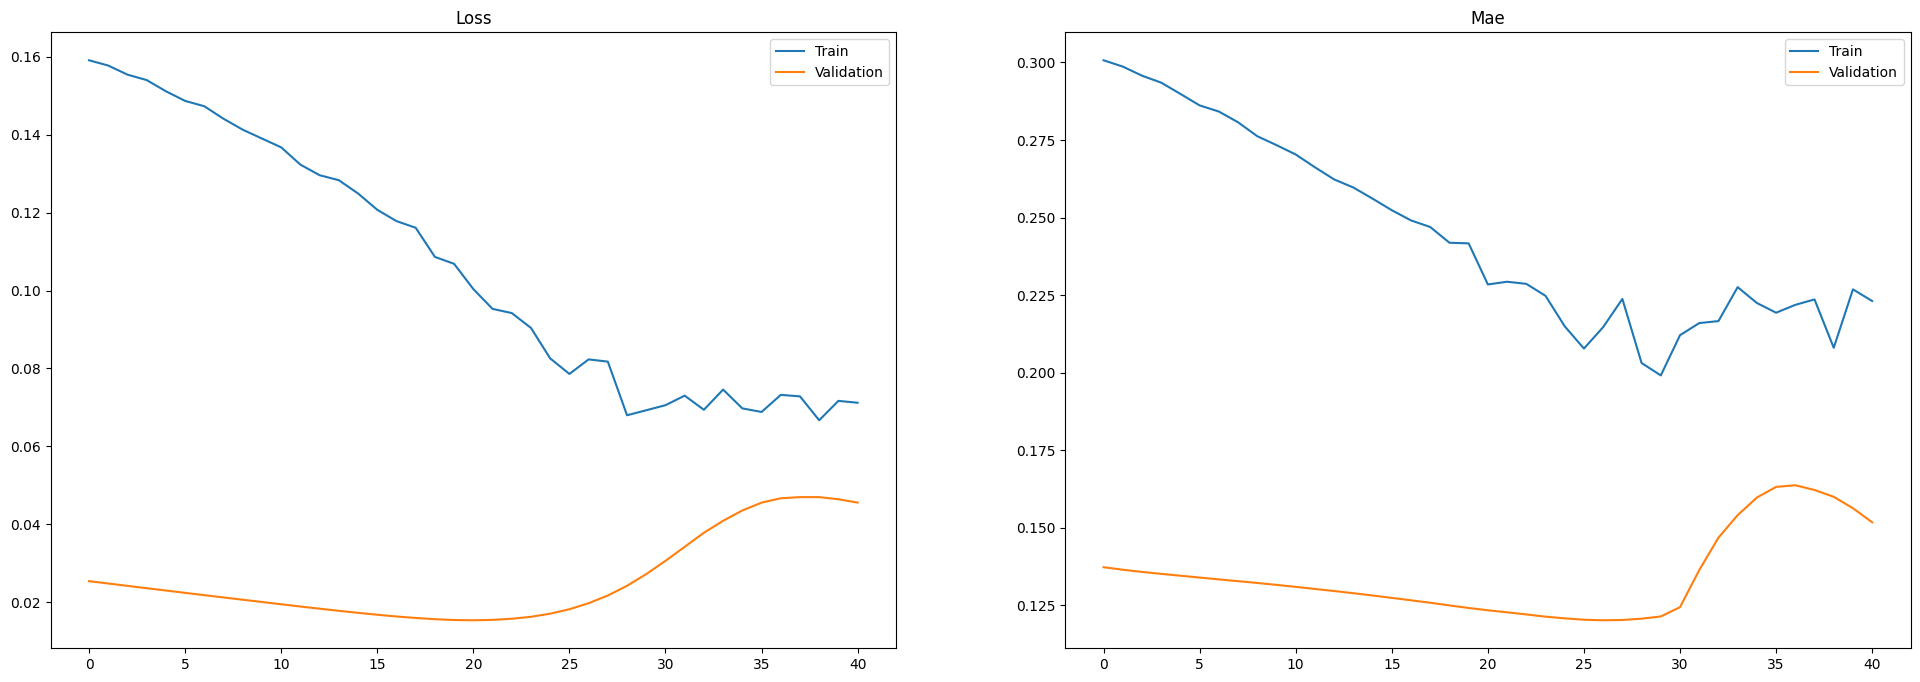

1/1 [==============================] - 1s 1s/step


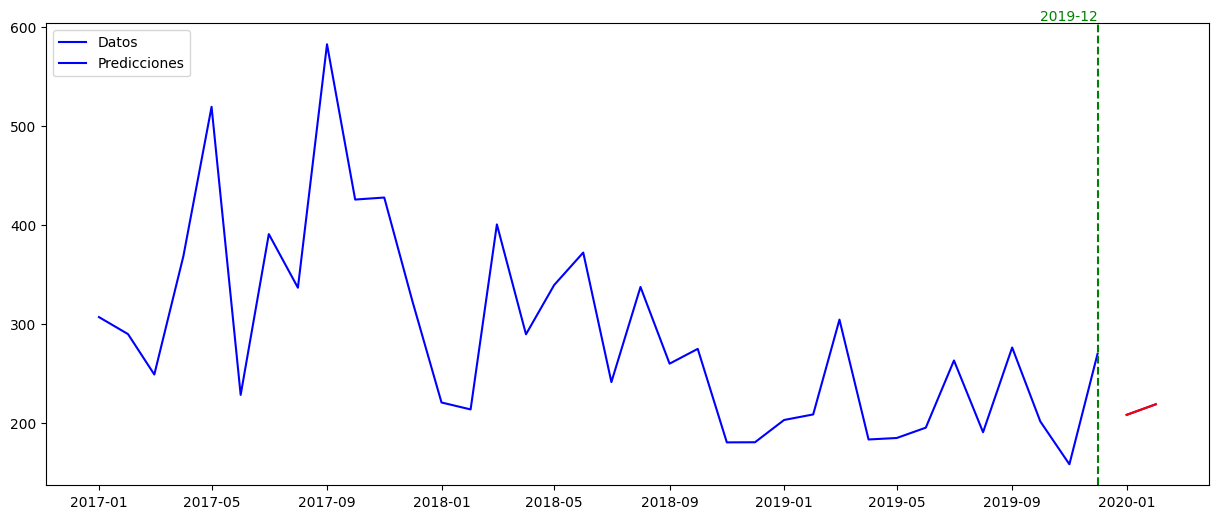

periodo
2020-01-01   207.75
2020-02-01   218.41
Name: 20024, dtype: float64

In [53]:
# Analizamos las series de los productos mas vendidos, vemos si las redes neuronales pueden entenderlas

# Modificar el valor del filtro, para analizar otros Productos. Ojo que hay productos que no tenemos todos los anos y pincha
# data_product = data_grouped['20024']
data_product = group_data(data.query('product_id == "20024"'), 'product_id')


data_train, data_valid = split_data_test(data_product)
data_train_norm, data_valid_norm, norm_params = normalize_data(data_train, data_valid, normalization)
data_train_windowed = windowed_dataset(data_train_norm, data_split='train', window_size=window_size, horizon=horizon, batch_size=batch_size)
data_valid_windowed = windowed_dataset(data_valid_norm, data_split='valid', window_size=window_size, horizon=horizon, batch_size=batch_size)

# Model Variables
model_name = 'xx'
loss = 'mse'
optimizer = 'adam'
patience = 20
epochs = 200
n_features = data_train.shape[1]


# Jugamos con esto aca, para ver el tema de la validacion en el entrenamiento
window_size = 3
batch_size = 1


callbacks = MyCallbacks(patience)
model = MyModel(loss, optimizer, window_size, horizon, n_features)

history = model.fit(
    data_train_windowed,
    validation_data = data_valid_windowed,
    callbacks = callbacks,
    verbose=0,
    epochs=epochs)

plot_history(history)

predictions = generate_predictions_2(model, data_valid_norm, norm_params)
plot_predictions(data_product, predictions)

### 06/15 - BASELINE + TOP Productos

In [54]:
# # # PARA LOCAL ONLY, DEMORA MUCHO

# #############################################################################################
# #############################################################################################
#  # El EDA tiene que estar arriba
# mask_product_id_sold36 = (data_grouped > 0).sum(axis=0)==36
# # print('Productos vendidos los 36 meses:', mask_product_id_sold36.sum())
# # mask_product_id_sold12 = (data_grouped > 0).sum(axis=0)<=12
# # print('Productos vendidos en 12 meses o menos:', mask_product_id_sold12.sum())

# # Marco los que se vendieron los 36 meses
# mask_products_id_top74 = mask_product_id_sold36

# # No me interesan los +75
# mask_products_id_top74.loc['20085':] = False
# mask_products_id_top74.sum()
# #############################################################################################
# #############################################################################################
# top_productos = data_productos_a_predecir[mask_products_id_top74].index

# # # Prueba con los dos primeros
# # top_productos = top_productos[:2]


# # # Continuacion a mano desde producto 20017
# # mask_17 = mask_products_id_top74.loc['20017':]
# # data_17 = data_productos_a_predecir.loc['20017':]
# # data_17[mask_17]
# # top_productos = data_17[mask_17].index

# data_prod_pred = data_productos_a_predecir.copy()
# data_prod_pred['mean'] = 0
# data_prod_pred['median'] = 0

# for producto in top_productos:
#   # print(f'Producto: {producto}')
#   data_grouped_loc = group_data(data, 'product_id')[producto]
#   # display(data_grouped_loc)

#   data_train, data_valid = split_data(data_grouped_loc)
#   data_train = pd.DataFrame(data_train)
#   data_valid = pd.DataFrame(data_valid)
#   # display(data_train.head())

#   data_train_norm, data_valid_norm, norm_params = normalize_data(data_train, data_valid, normalization)
#   # display(data_valid_norm.head())

#   data_train_windowed = windowed_dataset(data_train_norm, data_split='train', window_size=window_size, horizon=horizon, batch_size=batch_size)
#   data_valid_windowed = windowed_dataset(data_valid_norm, data_split='valid', window_size=window_size, horizon=horizon, batch_size=batch_size)

#   # Model Variables
#   model_name = 'M1'
#   loss = 'mse'
#   optimizer = 'adam'
#   patience = 20
#   epochs = 100
#   interaciones = 10
#   n_features = data_train.shape[1]
#   # print(n_features)


#   callbacks = MyCallbacks(patience)
#   model = MyModel(loss, optimizer, window_size, horizon, n_features)

#   # Promedio 810
#   mean, median = model_train(epochs, interaciones)
#   data_prod_pred.loc[producto, ['mean', 'median']] = mean, median

# # data_prod_pred.to_csv('predicciones_top74.csv', header=True, index=True)

### 06/15 - Nuevos BASELINES

In [55]:
# #########################################################################
# # Decomisionado                                                         #
# #########################################################################


# ####################################################################################################################
# # 2024-06-07: Excluyo las ventas de los clientes marcados como desactivados
# # Ventas de clientes que no compraron en los ultimos dos meses, eliminadas
# active_data = data[data['customer_id'].isin(mask_active_clients[mask_active_clients].index)]

# # Pivotear los datos
# data_grouped_active_clients = active_data.pivot_table(
#     index='periodo',
#     columns='product_id',
#     values='tn',
#     aggfunc='sum'
# )

# # Asegurarnos de que el índice esté en el formato correcto
# data_grouped_active_clients.index = pd.to_datetime(data_grouped_active_clients.index)

# # Ordenar el índice si fuera necesario
# data_grouped_active_clients = data_grouped_active_clients.sort_index()
# ####################################################################################################################

# # Comentar esta linea para que no se excluyan los clientes desactivados
# data_grouped = data_grouped_active_clients

# # Igual que Diciembre 2020 (ultimos datos)
# pred_202012 = data_grouped.loc['2019-12'].T.reset_index()
# pred_202012.columns = ['product_id', 'tn']

# # pred_202012.to_csv('BASELINE-pred_202012.csv', header=True, index=False)

# # Promedio ultimos 3 meses
# pred_mean3 = data_grouped.loc['2019-10':'2019-12'].T.mean(axis=1).reset_index()
# pred_mean3.columns = ['product_id', 'tn']

# # pred_mean3.to_csv('BASELINE-pred_mean3.csv', header=True, index=False)

# # Promedio ultimos 6 meses
# pred_mean6 = data_grouped.loc['2019-07':'2019-12'].T.mean(axis=1).reset_index()
# pred_mean6.columns = ['product_id', 'tn']

# # pred_mean6.to_csv('BASELINE-pred_mean6.csv', header=True, index=False)

# # Promedio ultimos 12 meses
# pred_mean12 = data_grouped.loc['2019-01':'2019-12'].T.mean(axis=1).reset_index()
# pred_mean12.columns = ['product_id', 'tn']

# pred_mean12.to_csv('BASELINE-pred_mean12_act4.csv', header=True, index=False)


### 06/12 - Walk Forward Validation
- Son muy pocos datos los que tenemos, no funciona bien

In [56]:
# # #########################################################################
# # # Decomisionado                                                         #
# # #########################################################################


# # #########################################################################
# # TimeSeriesSplit
# # #########################################################################
# n_splits = 3

# scaler = MinMaxScaler() # Probar con transformaciones no-lineales
# data = pd.DataFrame(scaler.fit_transform(data), columns=data.columns, index=data.index)
# # data_norm = data_grouped(data, 'product_id')


# # # TimeSeriesSplit: 3 splits para ejemplo
# # tscv = TimeSeriesSplit(n_splits=n_splits)

# # # Almacenar las pérdidas para cada split
# # split_losses = []

# # # Inicializo el vector de predicciones
# # predicciones_all = data_productos_a_predecir.copy()
# # predicciones_all['tn'] = 0

# # # Probar si esto se puede sacar del bucle
# # model_name = 'M1'
# # loss = 'mse'
# # optimizer = 'adam'
# # patience = 30
# # epochs = 500
# # callbacks = MyCallbacks(patience)
# # model = MyModel(loss, optimizer, window_size, horizon, n_features)


# # # Iterar sobre cada split
# # for i, (train_index, test_index) in enumerate(tscv.split(data_norm)):
# #     train_tscv = data_norm.iloc[train_index]
# #     test_tscv = data_norm.iloc[test_index]
# #     print('Train:\n', train_tscv.shape[0])
# #     print('Test:\n', test_tscv.shape[0])


# #     # Crear datasets de ventanas
# #     data_train_wrangled = windowed_dataset(train_tscv.values, 'train', window_size, horizon, batch_size)
# #     data_valid_wrangled = windowed_dataset(test_tscv.values, 'valid', window_size, horizon, batch_size)

# #     # Check if datasets are empty and adjust if necessary
# #     if len(list(data_train_wrangled)) == 0 or len(list(data_valid_wrangled)) == 0:
# #       print(f"Warning: Empty dataset encountered for split {i+1}. Skipping this split.")
# #       continue  # Skip to the next split

# #     history = model.fit(
# #     data_train_wrangled,
# #     validation_data = data_valid_wrangled,
# #     epochs=epochs,
# #     verbose=2,
# #     callbacks = callbacks)

# #     # Evaluar el modelo en el conjunto de validación
# #     val_loss = model.evaluate(data_valid_wrangled)
# #     print(f'Split {i+1} - Loss: {val_loss}')
# #     split_losses.append(val_loss)
# #     plot_history(history)

# #     predicciones_all = sumar_predicciones(predicciones_all, generate_predictions(False))


# # # Promedio de las pérdidas en todos los splits. El axis es por si analizamos mas de una metrica
# # avg_loss = np.mean(split_losses, axis=0)
# # print(f'Average Loss across all splits: {avg_loss}')

# # # Promedio las predicciones
# # predicciones_final = data_productos_a_predecir.copy()
# # predicciones_final['tn'] = predicciones_all['tn']/n_splits

# # # Exporto el CSV para Kaggle
# # filename = f"{split_strategy}_{model_name}_win{window_size}_batch{batch_size}_{normalization}_{loss}.csv"
# # predicciones_final.to_csv(filename, header=True, index=False)
# # print(filename)

### 06/11 - Agrupando por Categoria 1

In [57]:
# #########################################################################
# # Decomisionado                                                         #
# #########################################################################


# # Inicializo el vector de predicciones
# predictions_acum = data_productos_a_predecir.copy()
# predictions_acum['tn'] = 0
# # predictions_acum.set_index('product_id', inplace=True)
# predictions_acum = predictions_acum.squeeze()
# predictions_acum

# # Genero el vector de categorias
# categorias = data_productos_a_predecir_con_categorias.cat1.unique()

# # Creo un modelo para cada categoria 1
# for cat in categorias:
#   data_cat1 = filter_data_por_categoria(data_grouped, cat, 'cat1')
#   n_features = data_cat1.shape[1]
#   # display(data_cat1)
#   data_train_cat1, data_valid_cat1 = split_data(data_cat1)
#   print(f'Categoria {cat}: {data_train_cat1.shape}, {data_valid_cat1.shape}')
#   data_train_cat1_norm, data_valid_cat1_norm, data_norm_params = normalize_data(data_train_cat1, data_valid_cat1, normalization)
#   data_train_windowed = windowed_dataset(data_train_cat1_norm, data_split='train', window_size=window_size, horizon=horizon, batch_size=batch_size)
#   data_valid_windowed = windowed_dataset(data_train_cat1, data_split='valid', window_size=window_size, horizon=horizon, batch_size=batch_size)

#   # Creo que tengo que llenar los huecos

#   # Model Variables
#   model_name = 'CAT1'
#   loss = 'mse'
#   optimizer = 'adam'
#   patience = 50
#   epochs = 500
#   callbacks = MyCallbacks(patience)
#   model = MyModel(loss, optimizer, window_size, horizon, n_features)

#   history = model.fit(
#       data_train_windowed,
#       validation_data = data_valid_windowed,
#       callbacks = callbacks,
#       verbose=0,
#       epochs=epochs)

#   plot_history(history)

# #   # Seleccionar los últimos x meses de data_train
# #   data_for_prediction = data_train_cat1[-window_size:]
# #   # Convierte los datos a un formato compatible con la función window_dataset
# #   data_for_prediction = data_for_prediction.values.reshape((1, window_size, n_features))
# #   predictions = model.predict(data_for_prediction)

# #   # # Convertir las predicciones a un DataFrame para desnormalizar
# #   predictions_df = pd.DataFrame(predictions[0], columns=data_train_cat1.columns)

# #   # # Desnormalizar las predicciones
# #   predictions_denorm_cat1 = denormalize_series(predictions_df, data_norm_params, normalization=normalization).iloc[1]

# #   # Voy sumando las predicciones de cada categoria
# #   predictions_acum = predictions_acum.add(predictions_denorm_cat1, fill_value=0)

# # # Exporto a formato Kaggle
# # predictions_acum_df = pd.DataFrame(predictions_acum).reset_index()
# # predictions_acum_df.columns = ['product_id', 'tn']
# # filename = f"{model_name}_{split_strategy}_win{window_size}_batch{batch_size}_{normalization}_{loss}.csv"
# # predictions_acum_df.to_csv(filename, header=True, index=False)
# # print(filename)

### 06/11 - Analisis del Error por Producto

In [58]:
# #########################################################################
# # Decomisionado                                                         #
# #########################################################################


# #########################################################################
# # Train hasta 2019-10, para predecir 2019-12
# #########################################################################

# # split_data_2019
# data_filled = fill_nulls(data_grouped)
# data_train, data_valid, data_test = split_data_2019(data_filled)
# data_train = pd.DataFrame(data_train)
# data_valid = pd.DataFrame(data_valid)
# data_test = pd.DataFrame(data_test)
# print(data_train.shape, data_valid.shape, data_test.shape)


# data_train_norm, data_valid_norm, data_norm_params = normalize_data(data_train, data_valid, normalization)
# data_train_windowed = windowed_dataset(data_train_norm, data_split='train', window_size=window_size, horizon=horizon, batch_size=batch_size)
# data_valid_windowed = windowed_dataset(data_valid_norm, data_split='valid', window_size=window_size, horizon=horizon, batch_size=batch_size,)
# display(data_test)

# # Al hacer el split disitnto, hay que modificar esto sino me voy de rango creando las window
# # split_strategy = 'S1'
# # window_size = 3
# # horizon = 2
# # batch_size = 1
# # normalization = 'MinMax'

# # Model Variables
# model_name = 'ErrorAnalysis'
# loss = 'mse'
# optimizer = 'adam'
# patience = 20
# epochs = 200
# n_features = data_train.shape[1]

# callbacks = MyCallbacks(patience)
# model = MyModel(loss, optimizer, window_size, horizon, n_features)

# history = model.fit(
#     data_train_windowed,
#     validation_data = data_valid_windowed,
#     callbacks = callbacks,
#     verbose=2,
#     epochs=epochs)

# plot_history(history)

# # # No sirve para este caso, esta hardcodeada a Febrero 2020. Tengo que actualizar esta funcion
# # # generate_predictions(data_norm, data_norm_params)

# # # Seleccionar los últimos x meses de data_train
# # data_for_prediction = data_train[-window_size:]
# # # Convierte los datos a un formato compatible con la función window_dataset
# # data_for_prediction = data_for_prediction.values.reshape((1, window_size, n_features))
# # predictions = model.predict(data_for_prediction)

# # # Convertir las predicciones a un DataFrame para desnormalizar
# # predictions_df = pd.DataFrame(predictions[0], columns=data_train.columns)

# # # Desnormalizar las predicciones
# # predictions_denorm = denormalize_series(predictions_df, data_norm_params, normalization=normalization)

# # # Imprimir las predicciones desnormalizadas
# # # display(predictions_denorm)


# # # Genero las Series para plotear el error entre predicho y real. Armo un Dataframe
# # data_dec2019_pred = pd.Series(predictions_denorm.iloc[1], name='Pred')
# # data_dec2019_true = pd.Series(data_grouped.fillna(0).loc['2019-12-01'], name='True')
# # data_dec2019_error = pd.concat([data_dec2019_pred, data_dec2019_true], axis=1)

# # # Clusterizo por Categorias 1 y 2 de productos
# # data_productos_indexed = data_productos.drop_duplicates('product_id').set_index('product_id').sort_index()
# # data_dec2019_error_detail = data_dec2019_error.join(data_productos_indexed[['cat1', 'cat2', 'cat3']])

# # # Ploteo los Errores, con sus clusters
# # sns.scatterplot(data=data_dec2019_error_detail, x='Pred', y='True', hue='cat1')
# # plt.axline((0, 0), slope=1, color='r', linestyle='--')
# # plt.show()

# # # Verificamos que Categoria es la que engloba mas productos
# # print(data_productos['cat1'].value_counts())

# # # Productos con mayores diferencias en la prediccion
# # predictions_worst10 = abs(data_dec2019_pred - data_dec2019_true).sort_values(ascending=False).head(10)
# # display(pd.DataFrame(predictions_worst10).join(data_productos[['product_id', 'cat1']].set_index('product_id').sort_index()).rename(columns={0: 'tn_diff'}).sort_values(by='tn_diff', ascending=False))

# # # Ploteamos el error en las predicciones acumulaod por Categoria
# # pd.DataFrame(abs(data_dec2019_pred - data_dec2019_true).sort_values(ascending=False)).join(data_productos[['product_id', 'cat1']].set_index('product_id').sort_index()).rename(columns={0: 'tn_diff'}).groupby('cat1').sum().sort_values(by='tn_diff', ascending=False).plot(kind='bar')
# # plt.title('Diferencia en toneladas por Categoria')
# # plt.show()

- Vemos claramente como estsamos prediciendo mal los productos de Health Care, mas que nada los que predice entre 350 y 600, esta prediciendo bastante de menos.

### 06/10 - Cada cliente por separado

In [59]:
# # Esto lo corro en mi maquina local, en Colab se cuelga antes de terminar con los casi 600 clientes

# # Inicializo el vector de predicciones
# predicciones_all = data_productos_a_predecir.copy()
# predicciones_all['tn'] = 0

# # Probamos solo con los 3 primeros clientes
# # customers = data['customer_id'].unique()
# customers = ['10001', '10002', '10003']
# customers.sort()

# i = 0

# for customer in customers:
#   print('Vuelta: ', i)
#   i += 1
#   data_customer = data_filter.query('customer_id == @customer')
#   data_customer_grouped = group_data(data_customer, 'product_id')
#   data_customer_grouped_fixed = complete_sales(data_customer_grouped, data_productos_a_predecir)
#   # display(data_customer_grouped_fixed)
#   data_customer_filled = fill_nulls(data_customer_grouped_fixed) # Probar cual funciona mejor

#     # Probamos reemplazando la crisis de Agosto 2019 por el promedio en Julio y Septiembre. Maybe no funciona
#   data_customer_filled.drop(index='2019-08', axis=1, inplace=True)
#   data_agosto_2019 = data_customer_filled.loc[['2019-07', '2019-09']].mean().to_frame().transpose()
#   data_agosto_2019.index = pd.to_datetime(['2019-08-01'])
#   data_customer_filled = pd.concat([data_customer_filled, data_agosto_2019]).sort_index()

#   data_customer_norm, data_customer_norm_params = normalize_data(data_customer_filled, normalization=normalization)
#   data_customer_norm_train, data_customer_norm_valid = split_data(data_customer_norm)
#   data_train_windowed = windowed_dataset(data_customer_norm_train, data_split='train', window_size=window_size, horizon=horizon, batch_size=batch_size)
#   data_valid_windowed = windowed_dataset(data_customer_norm_valid, data_split='valid', window_size=window_size, horizon=horizon, batch_size=batch_size)

#   # Model Variables
#   model_name = 'M1'
#   loss = 'mse'
#   optimizer = 'adam'
#   patience = 30
#   epochs = 500
#   callbacks = MyCallbacks(patience)
#   model = MyModel(loss, optimizer, window_size, horizon, n_features)

#   history = model.fit(
#       data_train_windowed,
#       validation_data = data_valid_windowed,
#       callbacks = callbacks,
#       verbose=0,
#       epochs=epochs)

#   plot_history(history)


#   predicciones = generate_predictions(data_customer_norm, data_customer_norm_params, False)
#   predicciones_all = sumar_predicciones(predicciones_all, predicciones)

# predicciones_all.to_csv('predicciones_local.csv', header=True, index=False)

### 06/10 - No Split

In [60]:
# #########################################################################
# # Decomisionado                                                         #
# #########################################################################


# #########################################################################
# # Sin Splitear los datos, usando todo para entrenar
# #########################################################################

# # data_train, data_valid = split_data(group_data(data, 'product_id'), window_size)
# data_train_windowed = windowed_dataset(data_train, data_split='train', window_size=window_size, horizon=horizon, batch_size=batch_size)
# # data_valid_windowed = windowed_dataset(data_valid, data_split='valid', window_size=window_size, horizon=horizon, batch_size=batch_size)

# # Model Variables
# model_name = 'M1'
# # loss = 'mse'
# # optimizer = 'adam'
# # patience = 30
# epochs = 10

# model = MyModel(loss, optimizer, window_size, horizon, n_features)


# history = model.fit(
#     data_train_windowed,
#     # validation_data = data_valid_windowed,
#     # callbacks = callbacks,
#     verbose=2,
#     epochs=epochs)

# plot_history(history)
# predicciones = generate_predictions(True)
# predicciones

### 06/10 - Split #2

In [61]:
# #########################################################################
# # Decomisionado                                                         #
# #########################################################################


# #########################################################################
# Train desde 2017-01 hasta 2019-06
# #########################################################################

# data_train, data_valid = split_data(group_data(data, 'product_id'), window_size)
# data_train_windowed = windowed_dataset(data_train, data_split='train', window_size=window_size, horizon=horizon, batch_size=batch_size)
# data_valid_windowed = windowed_dataset(data_valid, data_split='valid', window_size=window_size, horizon=horizon, batch_size=batch_size)

# # Model Variables
# model_name = 'M1'
# loss = 'mse'
# optimizer = 'adam'
# patience = 30
# epochs = 500

# callbacks = MyCallbacks(patience)
# model = MyModel(loss, optimizer, window_size, horizon, n_features)


# history = model.fit(
#     data_train_windowed,
#     validation_data = data_valid_windowed,
#     callbacks = callbacks,
#     verbose=2,
#     epochs=epochs)

### 06/10 - Split #1

In [62]:
# #########################################################################
# # Decomisionado                                                         #
# #########################################################################


# # #########################################################################
# # Train 2018 & 2018, Validation 2019 (10/06)
# # #########################################################################

# window_size = 6

# data_train, data_valid = split_data(group_data(data, 'product_id'), window_size)
# data_train_windowed = windowed_dataset(data_train, data_split='train', window_size=window_size, horizon=horizon, batch_size=batch_size)
# data_valid_windowed = windowed_dataset(data_valid, data_split='valid', window_size=window_size, horizon=horizon, batch_size=batch_size)

# # Model Variables
# model_name = 'M1'
# loss = 'mse'
# optimizer = 'adam'
# patience = 30
# epochs = 500
# n_features = data_train.shape[1]

# callbacks = MyCallbacks(patience)
# model = MyModel(loss, optimizer, window_size, horizon, n_features)

# history = model.fit(
#     data_train_windowed,
#     validation_data = data_valid_windowed,
#     callbacks = callbacks,
#     verbose=2,
#     epochs=epochs)

# plot_history(history)
# preddicciones = generate_predictions(True)
# preddicciones

### Proof of Concept

In [63]:
# #########################################################################
# Decomisionado                                                           #
# #########################################################################


#########################################################################
# New Pipeline (09/06)
# #########################################################################
# data_norm, data_norm_params = normalize_data(data_filled, normalization=normalization)
# # data_train, data_valid = split_data(data_norm) # Split pendiente
# data_train = data_norm
# print(data_train.shape)
# # print(data_valid.shape)
# data_train_windowed = window_dataset(data_train, data_split='train', window_size=window_size, batch_size=batch_size, n_future=n_future)
# # data_valid_windowed = window_dataset(data_valid, data_split='valid', window_size=window_size, batch_size=batch_size, n_future=n_future)


# #########################################################################
# # Old Pipeline (08/06)
# #########################################################################
# # data_all = group_data(data, data_productos_a_predecir)
# # data_all_norm, data_all_norm_params = normalize_data(data_all, normalization=normalization)
# # data_all_norm['20001'].describe()
# # data_train, data_valid = split_data_all(data_all_norm)
# # print(data_train.shape)
# # print(data_valid.shape)
# # data_train = data_all_norm
# # data_train_windowed = window_dataset(data_train, data_split='train', window_size=window_size, batch_size=batch_size, n_future=n_future)
# # data_valid_windowed = window_dataset(data_valid, data_split='valid', window_size=window_size, batch_size=batch_size, n_future=n_future)


# #########################################################################
# # Modelo
# #########################################################################
# data_train, data_valid = split_data_1(data_norm)
# data_train_windowed = window_dataset(data_train, data_split='train', window_size=window_size, batch_size=batch_size, n_future=n_future)
# data_valid_windowed = window_dataset(data_valid, data_split='valid', window_size=window_size, batch_size=batch_size, n_future=n_future)

# # Model Variables
# model_name = 'M1'
# loss = 'mse'
# optimizer = 'adam'
# patience = 30
# epochs = 500

# callbacks = MyCallbacks(model_name, patience)
# model = MyModel(loss, optimizer, window_size, n_future, n_features)

# history = model.fit(
#     data_train_windowed,
#     validation_data = data_valid_windowed,
#     callbacks = callbacks,
#     verbose=2,
#     epochs=epochs)

# generate_predictions()

# EDA Inicial

## Objetivos Preeliminares
* [x] Algunos productos por promedio, otros por red neuronal. Identificar cuales
 (los que no tengo ventas todos o la mayoria de los meses)
*[x] Saber como fueron las ventas en cada Agosto, comparado con Julio y Septiembre del mismo ano. Esto para poder sortear el problema de la no ventas en Agosto 2018
*[x] Entender la distribucion de ventas por categoria
*[ ] Entender la distribucion de los errores por categoria
*[ ] entrenar en 2017 y 2018, y predecir feb 2019, teniendo en cuenta el trend negativo de alguna manera
*[ ] Saber si la serie de todos los productos por categoria, son similares
*[ ] Dividr las ventas por tipo de calidad de producto (Alto, Media Bajo), pedirlo si no esta
*[ ] Ver el error por producto, para saber cual analizar individualmente
*[ ] Identificar los productos mas importantes, separarlos por categoria, y fijarse si las series son similares. No con todos, maybe los 150 orimeros solametne
*[ ] Probar Unvariado en cada producto?



In [64]:
# # Plot de Ventas General
# data.groupby(['periodo'])['tn'].sum().plot()
# plt.show()

# # Deidentificacionde los productos y clientes
# # Evidentemente cuando el profe deidentifico los customers, lo hizo asignandoles ID secuenciales al listado ordenado por la suma de ventas(tn)
# print('Listado de Clientes, ordenados por la sumatoria de ventas en tn:\n', group_data(data, 'customer_id').sum(), '\n')

# # Lo mismo cuando deidentifico a los productos, solo que esta vez empezo desde 20000
# print('Listado de Productos, ordenados por la sumatoria de ventas en tn:\n', group_data(data, 'product_id').sum())

* Vemos la Tendencia Negativa
* Tambien vemos la seasonalidad anual, y mas chica puede que tabien
* Tambien se ve la caida en 2019-08, ya que decidimos no vender ese mes

## Top 74

In [65]:
# mask_product_id_sold36 = (group_data(data, 'product_id') > 0).sum(axis=0)==36
# print('Productos vendidos los 36 meses:', mask_product_id_sold36.sum())
# mask_product_id_sold12 = (group_data(data, 'product_id') > 0).sum(axis=0)<=12
# print('Productos vendidos en 12 meses o menos:', mask_product_id_sold12.sum())


* Vamos a ver de el TOP 74 (hasta ID 84) de los productos mas vendidos, y solo los product_id 20032 y 20089 no se vendieron los 36 meses


In [66]:
# group_data(data.query("product_id == '20032' or product_id == '20089'"), 'product_id').plot(figsize=(15, 5), title='Productos Top75 que no se vendieron los 36 meses')
# plt.show()

* Uno se empezo a vender en 2019-02, y el otro 2018-07

## Analisis Agosto 2019

In [67]:
# group_data(data, 'product_id').loc['2017-06':'2017-10'].sum(axis=1).plot(title='Agosto crece-crece en 2017')
# plt.show()

# group_data(data, 'product_id').loc['2018-06':'2018-10'].sum(axis=1).plot(title='Agosto crece-decrece en 2018')
# plt.show()

* Pareciera ser que siempre sube un 10% con respecto al Julio anterior

## Analysis por Categoria

In [68]:
# data_productos_con_categorias[data_productos_con_categorias['product_id'].isin(data_productos_a_predecir.index)]['cat1'].value_counts().plot(kind='bar')
# plt.title('Productos por Categoria 1')
# plt.show()

* La categoria con mas productos es PC con 444

## Analisis Ventas en los Febreros

In [69]:
# # En 2017

# data_2017 =group_data(data, 'product_id').loc['2017'].mean(axis=0)
# feb_2017 = group_data(data, 'product_id').loc['2017-02']

# # Ploteamos 2017
# fig, ax = plt.subplots(figsize=(10, 6))
# # Ploteamos promedio del 2017
# data_2017[:50].plot(ax=ax, label='Promedio 2017')
# # Ploteamos Febrero 2017
# feb_2017.T[:50].plot(ax=ax, label='Febrero 2017')
# ax.legend()
# plt.show()
# # Vemos como el promedio anual y las ventas de Feb tienen una cierta relacion

# # Calculamos el ratio que Febrero corresponde al promedio anual
# diff_2017 = pd.Series(((data_2017- feb_2017)/feb_2017).T.squeeze(), name='diff')

# # Lo joineamos a las categorias
# diff_2017_cat = pd.concat([diff_2017, data_productos_con_categorias[data_productos_con_categorias['product_id'].isin(data_productos_a_predecir.index)][['cat1']]], axis=1)


# # # Analizamos (REVISAR)
# # diff_2017_cat.groupby('cat1')['diff'].mean().plot(kind='bar')
# # plt.title('Ratio ventas Proemdio Anual sobre Febrero en 2017')
# # plt.show()

# # display(diff_cat.sort_values(by='diff', ascending=False).head(30))
# # Vemos que ciertos productos de Personal Care no siguen el patron
# # Esto habra sido un problema puntual en 2017, el profe habia comentaso lo de las cremas?
# # Lo que si nos interesa es ver que HC y FOODS estan cerca del 0.5

## Que productos se vendieron los 36 meses

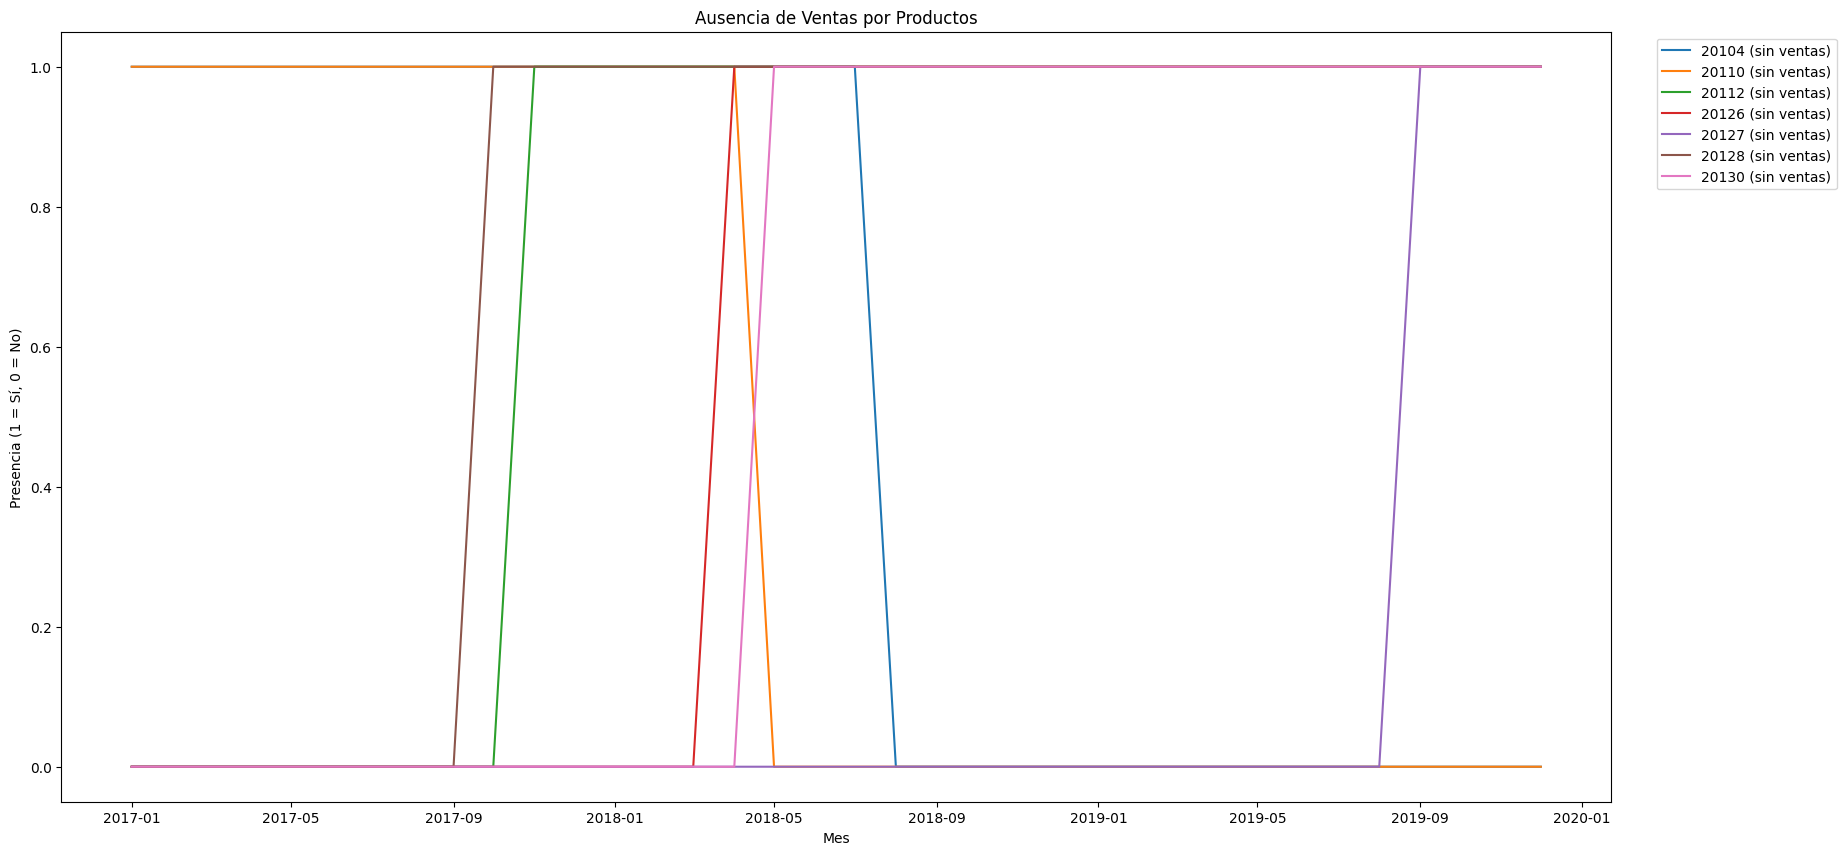

(['20104', '20110', '20104', '20110'],
 ['20112',
  '20126',
  '20127',
  '20128',
  '20130',
  '20112',
  '20126',
  '20127',
  '20128',
  '20130'])

In [70]:
# Verificamos como algunos productos se dejaron de comercializar antes de Diciembre 2019
# Tambien vemos como otros empezaron a comecializarse despues de Enero 2017
plot_products_sales(data_bkp, start=100, end=130)

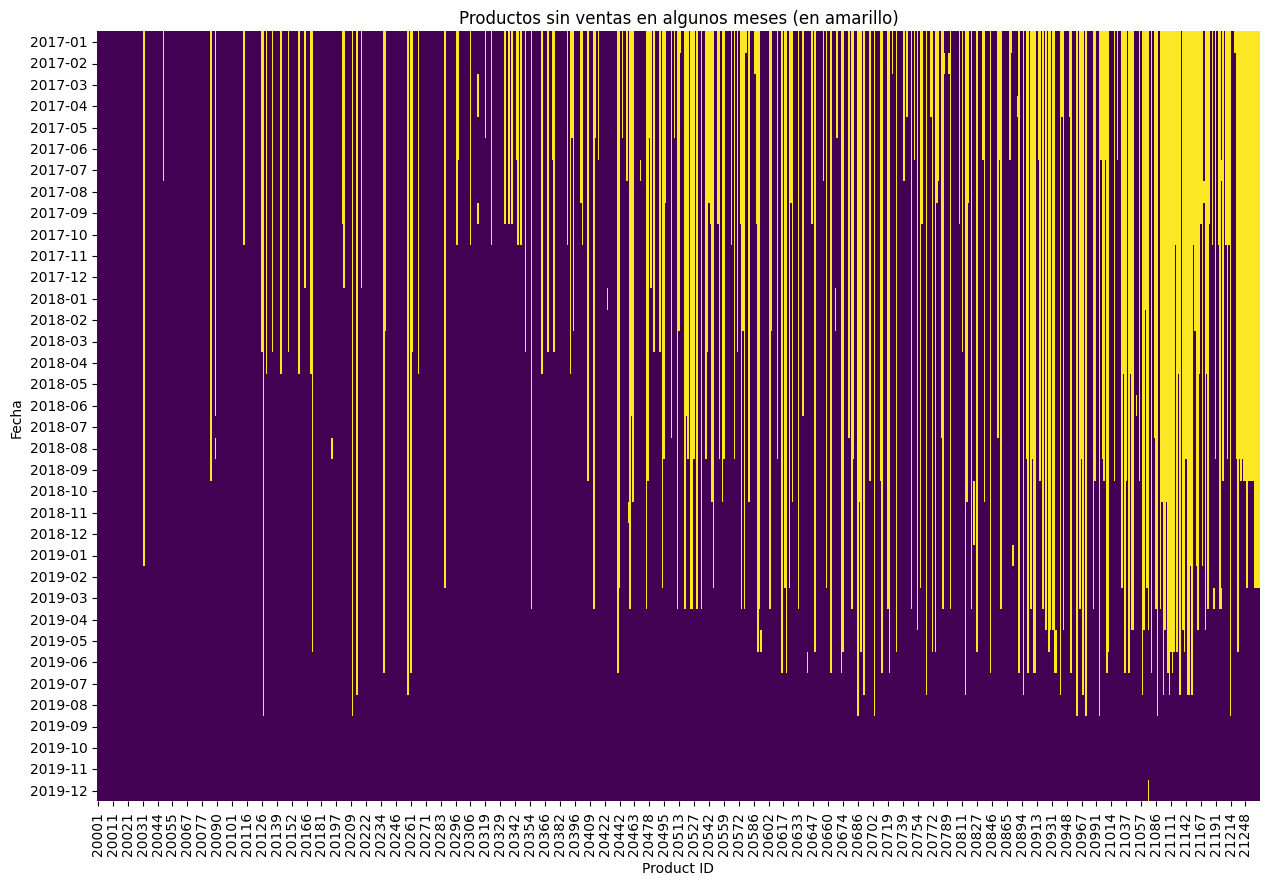

In [71]:
# Verificamos los productos con menos tiempo de exposicion en el mercado, se venden en menos cantidad
# Agregar esta variable al FE

# Verificamos si hay valores nulos en el DataFrame
null_data = group_data(data, 'product_id').isnull()

# Creamos el heatmap para visualizar los valores nulos
plt.figure(figsize=(15, 10))
sns.heatmap(null_data, cmap='viridis', cbar=False)
plt.gca().set_yticklabels(null_data.index.strftime('%Y-%m')) # Formateo de las etiquetas del eje y
plt.title('Productos sin ventas en algunos meses (en amarillo)')
plt.xlabel('Product ID')
plt.ylabel('Fecha')
plt.show()

# Se observan que algunos productos que no se vendieron en meses puntuales, se habra roto la maquina?

periodo,2019-12-01
21074,True


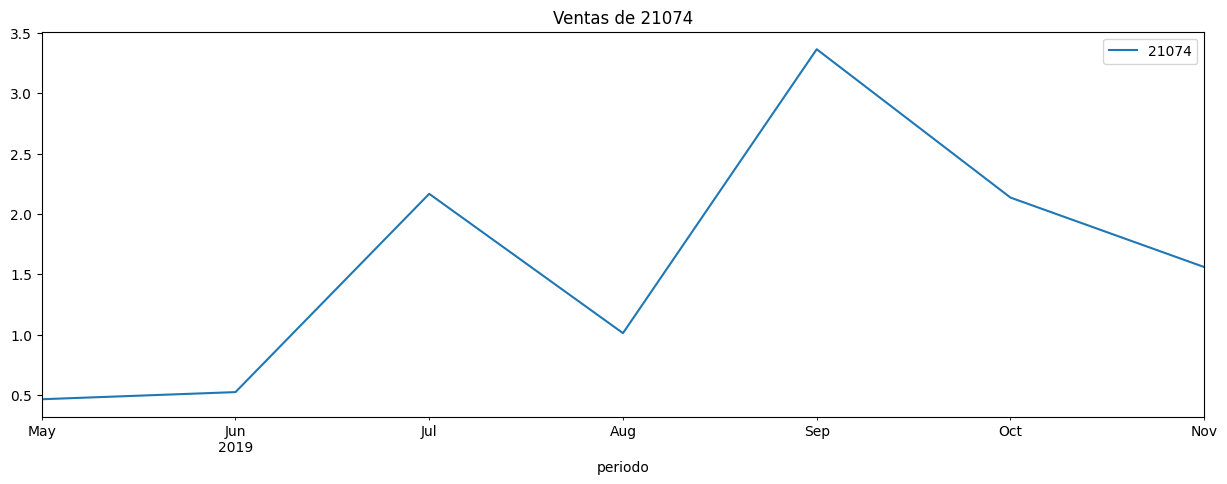

In [72]:
# Tambien pareciera ser que el producto 21074 se dejo de vender en Dic 2019. Deberiamos predecir 0 para Feb 2020?
display(null_data.loc['2019-12'].T[null_data.loc['2019-12'].T == True].dropna())

# Aunque en la grafica no lo parece. Se abra roto la maquina en Dec 2019?
group_data(data.query('product_id == "21074"'), "product_id").plot(figsize=(15, 5), title='Ventas de 21074')
plt.show()